### NN models with PyTorch

In [11]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time

In [12]:
# Set up IMDB dataset... since the tweets don't give us much to work with

def load_and_preprocess_data(n_samples=1000):
    imdb_df = pd.read_csv("IMDB Dataset.csv")
    
    # Sample data for faster experimentation
    df_positive = imdb_df[imdb_df['sentiment']=='positive'][:n_samples//2]
    df_negative = imdb_df[imdb_df['sentiment']=='negative'][:n_samples//2]
    imdb = pd.concat([df_positive, df_negative])
    
    print(f"Dataset shape: {imdb.shape}")
    
    # Text cleaning
    def clean_text(text):
        # Remove HTML tags
        text = re.sub(r'<.*?>', ' ', text)
        # Remove punctuation and special characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Convert to lowercase
        text = text.lower()
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text
    
    imdb['review'] = imdb['review'].apply(clean_text)
    
    # Convert sentiment to binary
    imdb['sentiment'] = imdb['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
    
    return imdb

# Load data
data = load_and_preprocess_data(n_samples=2000)
print(f"Positive samples: {sum(data['sentiment'])}")
print(f"Negative samples: {len(data) - sum(data['sentiment'])}")

Dataset shape: (2000, 2)
Positive samples: 1000
Negative samples: 1000


In [13]:
# Text Tokenization and Vocabulary Building
def build_vocabulary(texts, min_freq=2):
    """
    Build vocabulary from texts
    """
    # Tokenize texts
    all_tokens = []
    for text in texts:
        tokens = word_tokenize(text)
        all_tokens.extend(tokens)
    
    # Count token frequencies
    token_counts = Counter(all_tokens)
    
    # Create vocabulary with special tokens
    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    
    for token, count in token_counts.items():
        if count >= min_freq:
            vocab[token] = idx
            idx += 1
    
    print(f"Vocabulary size: {len(vocab)}")
    return vocab

def text_to_sequences(texts, vocab, max_length=100):
    """
    Convert texts to sequences of indices
    """
    sequences = []
    for text in texts:
        tokens = word_tokenize(text)
        sequence = [vocab.get(token, vocab['<UNK>']) for token in tokens]
        # Pad or truncate to max_length
        if len(sequence) > max_length:
            sequence = sequence[:max_length]
        else:
            sequence.extend([vocab['<PAD>']] * (max_length - len(sequence)))
        sequences.append(sequence)
    
    return np.array(sequences)

# Build vocabulary and convert texts to sequences
vocab = build_vocabulary(data['review'])
max_length = 100
sequences = text_to_sequences(data['review'], vocab, max_length)
labels = data['sentiment'].values

print(f"Sequence shape: {sequences.shape}")
print(f"Labels shape: {labels.shape}")

Vocabulary size: 14215
Sequence shape: (2000, 100)
Labels shape: (2000,)


In [14]:
# Base case with default hyperparameters

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


Using device: cpu


In [16]:
# Load and preprocess IMDB dataset (using the same approach as TensorFlow version)
def load_imdb_data(vocab_size=10000, max_length=200, test_size=0.2):
    """
    Load and preprocess IMDB dataset for PyTorch
    """

    df = pd.read_csv("IMDB Dataset.csv")
    # Convert to the format expected by our models
    texts = df['review'].tolist()
    labels = (df['sentiment'] == 'positive').astype(int).tolist()
    
    # Use our existing vocabulary building function
    vocab = build_vocabulary(texts, min_freq=2)
    
    # Limit vocabulary size
    if len(vocab) > vocab_size:
        # Keep most frequent words
        word_counts = Counter()
        for text in texts:
            tokens = word_tokenize(text.lower())
            word_counts.update(tokens)
        
        # Create limited vocabulary
        most_common = word_counts.most_common(vocab_size - 4)  # Reserve 4 for special tokens
        limited_vocab = {'<PAD>': 0, '<UNK>': 1, '<START>': 2, '<UNUSED>': 3}
        for i, (word, _) in enumerate(most_common):
            limited_vocab[word] = i + 4
        
        vocab = limited_vocab
    
    # Convert texts to sequences
    sequences = text_to_sequences(texts, vocab, max_length)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        sequences, labels, test_size=test_size, random_state=42, stratify=labels
    )
    
    return (X_train, y_train), (X_test, y_test), vocab

# Load data
(X_train, y_train), (X_test, y_test), vocab = load_imdb_data()
vocab_size = len(vocab)
max_length = 200

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Max sequence length: {max_length}")


Vocabulary size: 94011
Training samples: 40000
Test samples: 10000
Vocabulary size: 10000
Max sequence length: 200


In [17]:
# Create PyTorch DataLoaders
def create_data_loaders(X_train, y_train, X_test, y_test, batch_size):
    """
    Create PyTorch DataLoaders for training and testing
    """
    # Convert to PyTorch tensors
    X_train_tensor = torch.LongTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.LongTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Create datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

# Create data loaders (default batch size 64)
train_loader, test_loader = create_data_loaders(X_train, y_train, X_test, y_test, 64)
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


Training batches: 625
Test batches: 157


In [18]:
# Define PyTorch Models - Base Case with Default Hyperparameters

class RNNModel(nn.Module):
    """
    Simple RNN model for text classification
    Default hyperparameters matching TensorFlow version
    """
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=64, num_classes=2, dropout=0.0):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        rnn_out, _ = self.rnn(embedded)  # (batch_size, seq_length, hidden_size)
        # Take the last output
        last_output = rnn_out[:, -1, :]  # (batch_size, hidden_size)
        dropped = self.dropout(last_output)
        output = self.fc(dropped)  # (batch_size, num_classes)
        return output

class LSTMModel(nn.Module):
    """
    LSTM model for text classification
    Default hyperparameters matching TensorFlow version
    """
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=64, num_classes=2, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_length, hidden_size)
        # Take the last output
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_size)
        dropped = self.dropout(last_output)
        output = self.fc(dropped)  # (batch_size, num_classes)
        return output

class GRUModel(nn.Module):
    """
    GRU model for text classification
    Default hyperparameters matching TensorFlow version
    """
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=64, num_classes=2, dropout=0.0):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        gru_out, _ = self.gru(embedded)  # (batch_size, seq_length, hidden_size)
        # Take the last output
        last_output = gru_out[:, -1, :]  # (batch_size, hidden_size)
        dropped = self.dropout(last_output)
        output = self.fc(dropped)  # (batch_size, num_classes)
        return output


In [50]:
# Training and Evaluation Functions

def train_model(model, train_loader, test_loader, epochs=3, learning_rate=0.001, 
                model_name="Model", loss_function='CrossEntropyLoss', 
                gradient_clip=None, gradient_clip_type='norm', optimizer_type='Adam'):
    """
    Train a PyTorch model and return training history
    
    Args:
        model: PyTorch model to train
        train_loader: training data loader
        test_loader: validation data loader
        epochs: number of training epochs
        learning_rate: learning rate for optimizer
        model_name: name for logging
        loss_function: loss function ('CrossEntropyLoss', 'MSELoss', 'NLLLoss')
        gradient_clip: gradient clipping value (None for no clipping)
        gradient_clip_type: type of gradient clipping ('norm' or 'value')
        optimizer_type: optimizer type ('Adam', 'SGD', 'RMSprop')
    """
    model = model.to(device)
    
    # Select loss function
    if loss_function == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    elif loss_function == 'MSELoss':
        criterion = nn.MSELoss()
    elif loss_function == 'NLLLoss':
        criterion = nn.NLLLoss()
    else:
        raise ValueError(f"Unsupported loss function: {loss_function}")
    
    # Select optimizer
    if optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_type}")
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    print(f"\nTraining {model_name}...")
    print("-" * 50)
    if gradient_clip is not None:
        print(f"Gradient clipping: {gradient_clip_type} with value {gradient_clip}")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            
            # Handle different loss functions
            if loss_function == 'MSELoss':
                # Convert targets to one-hot encoding for MSELoss
                target_one_hot = torch.zeros(target.size(0), 2).to(device)
                target_one_hot.scatter_(1, target.unsqueeze(1), 1)
                loss = criterion(output, target_one_hot)
            elif loss_function == 'NLLLoss':
                # Apply log_softmax for NLLLoss
                output = F.log_softmax(output, dim=1)
                loss = criterion(output, target)
            else:  # CrossEntropyLoss
                loss = criterion(output, target)
            
            loss.backward()

             # Apply gradient clipping if specified
            if gradient_clip is not None:
                if gradient_clip_type == 'norm':
                    # Clip gradients by norm (L2 norm)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
                elif gradient_clip_type == 'value':
                    # Clip gradients by value (element-wise)
                    torch.nn.utils.clip_grad_value_(model.parameters(), gradient_clip)
                else:
                    raise ValueError(f"Unsupported gradient_clip_type: {gradient_clip_type}")
                
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        # Calculate training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                
                if loss_function == 'MSELoss':
                    target_one_hot = torch.zeros(target.size(0), 2).to(device)
                    target_one_hot.scatter_(1, target.unsqueeze(1), 1)
                    loss = criterion(output, target_one_hot)
                elif loss_function == 'NLLLoss':
                    output_log_probs = F.log_softmax(output, dim=1)
                    loss = criterion(output_log_probs, target)
                else:  # CrossEntropyLoss
                    loss = criterion(output, target)
                
                val_loss += loss.item()
                
                if loss_function == 'NLLLoss':
                    _, predicted = torch.max(output_log_probs, 1)
                else:
                    _, predicted = torch.max(output, 1)
                    
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        # Calculate validation metrics
        avg_val_loss = val_loss / len(test_loader)
        val_accuracy = 100 * val_correct / val_total
        
        # Store metrics
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'final_val_accuracy': val_accuracies[-1]
    }

def evaluate_model(model, test_loader, model_name="Model"):
    """
    Evaluate model and return detailed metrics
    """
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    
    print(f"\n{model_name} Evaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_predictions,
        'targets': all_targets
    }


In [20]:
# Train and Evaluate RNN Model
print("=" * 60)
print("TRAINING RNN MODEL (Base Case - Default Hyperparameters)")
print("=" * 60)

# Create RNN model with default hyperparameters
rnn_model = RNNModel(vocab_size=vocab_size, embedding_dim=128, hidden_size=64, num_classes=2, dropout=0.0)

# Train the model
rnn_history = train_model(rnn_model, train_loader, test_loader, epochs=3, learning_rate=0.001, model_name="RNN")

# Evaluate the model
rnn_results = evaluate_model(rnn_model, test_loader, "RNN")


TRAINING RNN MODEL (Base Case - Default Hyperparameters)

Training RNN...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6973, Train Acc: 50.73%
  Val Loss: 0.6947, Val Acc: 51.11%
Epoch 2/3:
  Train Loss: 0.6866, Train Acc: 53.72%
  Val Loss: 0.7077, Val Acc: 51.14%
Epoch 3/3:
  Train Loss: 0.6855, Train Acc: 54.40%
  Val Loss: 0.6934, Val Acc: 52.47%

RNN Evaluation Results:
Accuracy: 0.5247
Precision: 0.5345
Recall: 0.5247
F1-Score: 0.4885


In [ ]:
# Train and Evaluate LSTM Model
print("=" * 60)
print("TRAINING LSTM MODEL (Base Case - Default Hyperparameters)")
print("=" * 60)

# Create LSTM model with default hyperparameters
lstm_model = LSTMModel(vocab_size=vocab_size, embedding_dim=128, hidden_size=64, num_classes=2, dropout=0.0)

# Train the model
lstm_history = train_model(lstm_model, train_loader, test_loader, epochs=3, learning_rate=0.001, model_name="LSTM")

# Evaluate the model
lstm_results = evaluate_model(lstm_model, test_loader, "LSTM")


TRAINING LSTM MODEL (Base Case - Default Hyperparameters)

Training LSTM...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6919, Train Acc: 51.81%
  Val Loss: 0.6812, Val Acc: 56.92%
Epoch 2/3:
  Train Loss: 0.6626, Train Acc: 59.78%
  Val Loss: 0.6096, Val Acc: 67.89%
Epoch 3/3:
  Train Loss: 0.5420, Train Acc: 74.42%
  Val Loss: 0.5483, Val Acc: 74.17%

LSTM Evaluation Results:
Accuracy: 0.7417
Precision: 0.7654
Recall: 0.7417
F1-Score: 0.7358


In [ ]:
# Train and Evaluate GRU Model
print("=" * 60)
print("TRAINING GRU MODEL (Base Case - Default Hyperparameters)")
print("=" * 60)

# Create GRU model with default hyperparameters
gru_model = GRUModel(vocab_size=vocab_size, embedding_dim=128, hidden_size=64, num_classes=2, dropout=0.0)

# Train the model
gru_history = train_model(gru_model, train_loader, test_loader, epochs=3, learning_rate=0.001, model_name="GRU")

# Evaluate the model
gru_results = evaluate_model(gru_model, test_loader, "GRU")


TRAINING GRU MODEL (Base Case - Default Hyperparameters)

Training GRU...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6783, Train Acc: 55.46%
  Val Loss: 0.6621, Val Acc: 60.46%
Epoch 2/3:
  Train Loss: 0.4419, Train Acc: 79.45%
  Val Loss: 0.3495, Val Acc: 84.35%
Epoch 3/3:
  Train Loss: 0.2982, Train Acc: 87.51%
  Val Loss: 0.3224, Val Acc: 85.81%

GRU Evaluation Results:
Accuracy: 0.8581
Precision: 0.8589
Recall: 0.8581
F1-Score: 0.8580


# Visualisation Functions

### Compare Models

In [2]:
def plot_model_comparison(model_results, model_histories, hyperparams, experiment_name="Experiment"):
    """
    Create comprehensive visualizations for model comparison
    
    Args:
        model_results: dict with keys as model names and values as result dicts
        model_histories: dict with keys as model names and values as history dicts
        hyperparams: dict containing hyperparameter values used
        experiment_name: string name for the experiment
    """
    print("=" * 60)
    print(f"{experiment_name.upper()} - MODEL COMPARISON RESULTS")
    print("=" * 60)
    
    # Create comparison DataFrame
    comparison_data = []
    for model_name, results in model_results.items():
        comparison_data.append({
            'Model': model_name,
            'Accuracy': results['accuracy'],
            'Precision': results['precision'],
            'Recall': results['recall'],
            'F1-Score': results['f1']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\nPerformance Comparison:")
    print(comparison_df.round(4))
    
    # Plot training curves
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Define colors and markers for consistency
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    markers = ['o', 's', '^', 'D', 'v', '<']
    
    # Plot training accuracy
    for i, (model_name, history) in enumerate(model_histories.items()):
        axes[0, 0].plot(history['train_accuracies'], 
                       label=f'{model_name}', 
                       marker=markers[i % len(markers)],
                       color=colors[i % len(colors)])
    axes[0, 0].set_title('Training Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot validation accuracy
    for i, (model_name, history) in enumerate(model_histories.items()):
        axes[0, 1].plot(history['val_accuracies'], 
                       label=f'{model_name}', 
                       marker=markers[i % len(markers)],
                       color=colors[i % len(colors)])
    axes[0, 1].set_title('Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot training loss
    for i, (model_name, history) in enumerate(model_histories.items()):
        axes[1, 0].plot(history['train_losses'], 
                       label=f'{model_name}', 
                       marker=markers[i % len(markers)],
                       color=colors[i % len(colors)])
    axes[1, 0].set_title('Training Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Plot validation loss
    for i, (model_name, history) in enumerate(model_histories.items()):
        axes[1, 1].plot(history['val_losses'], 
                       label=f'{model_name}', 
                       marker=markers[i % len(markers)],
                       color=colors[i % len(colors)])
    axes[1, 1].set_title('Validation Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Confusion Matrices
    n_models = len(model_results)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))
    if n_models == 1:
        axes = [axes]
    
    for i, (model_name, results) in enumerate(model_results.items()):
        cm = confusion_matrix(results['targets'], results['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'{model_name} Confusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    # Print hyperparameters used
    print("\n" + "=" * 60)
    print("HYPERPARAMETERS USED")
    print("=" * 60)
    for key, value in hyperparams.items():
        print(f"  - {key}: {value}")
    
    # Print summary
    print("\n" + "=" * 60)
    print("SUMMARY")
    print("=" * 60)
    best_model = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']
    best_accuracy = comparison_df['Accuracy'].max()
    print(f"Best performing model: {best_model}")
    print(f"Highest accuracy: {best_accuracy:.4f}")
    
    return comparison_df


### Compare Hyperparameters

In [42]:
def run_hyperparameter_experiment(embedding_dim=128, hidden_size=64, dropout=0.0, 
                                 learning_rate=0.001, epochs=3, batch_size=64, 
                                 experiment_name="Experiment", plot_results=True,
                                 loss_function='CrossEntropyLoss', gradient_clip=None,
                                 gradient_clip_type='norm', optimizer_type='Adam'):
    """
    Run a complete experiment with specified hyperparameters (supports lists)
    
    Args:
        embedding_dim: embedding dimension (int or list)
        hidden_size: hidden layer size for RNN/LSTM/GRU (int or list)
        dropout: dropout rate (float or list)
        learning_rate: learning rate for optimizer (float or list)
        epochs: number of training epochs (int or list)
        batch_size: batch size for training (int or list)
        loss_function: loss function ('CrossEntropyLoss', 'MSELoss', 'NLLLoss')
        gradient_clip: gradient clipping value (None for no clipping)
        gradient_clip_type: type of gradient clipping ('norm' or 'value')
        optimizer_type: optimizer type ('Adam', 'SGD', 'RMSprop')
        experiment_name: name for this experiment (str or list)
        plot_results: whether to generate plots (bool)
    
    Returns:
        dict: nested dictionary with experiment results
        Structure: {experiment_name: {model_name: {results, history, hyperparams}}}
    """
    # Convert single values to lists for uniform processing
    def to_list(x):
        if x is None:
            return [None]
        return x if isinstance(x, list) else [x]
    
    embedding_dims = to_list(embedding_dim)
    hidden_sizes = to_list(hidden_size)
    dropouts = to_list(dropout)
    learning_rates = to_list(learning_rate)
    epochs_list = to_list(epochs)
    batch_sizes = to_list(batch_size)
    experiment_names = to_list(experiment_name)
    loss_functions = to_list(loss_function)
    gradient_clips = to_list(gradient_clip)
    gradient_clip_types = to_list(gradient_clip_type)
    optimizer_types = to_list(optimizer_type)
    
    # Generate all combinations
    from itertools import product
    
    all_experiments = {}
    
    for i, (emb_dim, hid_size, drop, lr, ep, batch, exp_name, loss_func, grad_clip, clip_type, opt_type) in enumerate(
        product(embedding_dims, hidden_sizes, dropouts, learning_rates, 
                epochs_list, batch_sizes, experiment_names, loss_functions,
                gradient_clips, gradient_clip_types, optimizer_types)):
        
        # Create unique experiment name if multiple parameters are varied
        if len(embedding_dims) > 1 or len(hidden_sizes) > 1 or len(dropouts) > 1 or \
           len(learning_rates) > 1 or len(epochs_list) > 1 or len(batch_sizes) > 1 or \
           len(loss_functions) > 1 or len(gradient_clips) > 1 or len(gradient_clip_types) > 1 or \
           len(optimizer_types) > 1:
            clip_suffix = f"_clip{grad_clip}_{clip_type}" if grad_clip is not None else "_noClip"
            exp_name = f"{exp_name}_emb{emb_dim}_hid{hid_size}_drop{drop}_lr{lr}_ep{ep}_bs{batch}_loss{loss_func}{clip_suffix}_opt{opt_type}"
        
        print(f"\n{'='*80}")
        print(f"RUNNING EXPERIMENT: {exp_name.upper()}")
        print(f"{'='*80}")
        
        # Create new data loaders with specified batch size
        train_loader, test_loader = create_data_loaders(X_train, y_train, X_test, y_test, batch_size=batch)
        
        # Initialize models with specified hyperparameters
        models = {
            'RNN': RNNModel(vocab_size=vocab_size, embedding_dim=emb_dim, 
                           hidden_size=hid_size, dropout=drop),
            'LSTM': LSTMModel(vocab_size=vocab_size, embedding_dim=emb_dim, 
                             hidden_size=hid_size, dropout=drop),
            'GRU': GRUModel(vocab_size=vocab_size, embedding_dim=emb_dim, 
                           hidden_size=hid_size, dropout=drop)
        }
        
        # Train and evaluate all models
        model_results = {}
        model_histories = {}
        
        for model_name, model in models.items():
            print(f"\nTraining {model_name}...")
            history = train_model(model, train_loader, test_loader, 
                        epochs=ep, learning_rate=lr, 
                        model_name=model_name,
                        loss_function=loss_func,
                        gradient_clip=grad_clip,
                        gradient_clip_type=clip_type,
                        optimizer_type=opt_type)
            results = evaluate_model(model, test_loader, model_name)
            
            model_results[model_name] = results
            model_histories[model_name] = history
        
        # Create hyperparameters dict
        hyperparams = {
            'Embedding dimension': emb_dim,
            'Hidden size': hid_size,
            'Dropout': drop,
            'Learning rate': lr,
            'Epochs': ep,
            'Batch size': batch,
            'Loss function': loss_func,
            'Gradient clip': grad_clip,
            'Gradient clip type': clip_type,
            'Optimizer': opt_type
        }
        
        # Store experiment results
        all_experiments[exp_name] = {
            'model_results': model_results,
            'model_histories': model_histories,
            'hyperparams': hyperparams
        }
        
        # Generate visualizations if requested and only for single experiments
        if plot_results and len(all_experiments) == 1:
            comparison_df = plot_model_comparison(
                model_results=model_results,
                model_histories=model_histories,
                hyperparams=hyperparams,
                experiment_name=exp_name
            )
            all_experiments[exp_name]['comparison_df'] = comparison_df
    
    return all_experiments

def run_batch_experiments(experiment_configs, plot_individual=False):
    """
    Run multiple experiments with different configurations
    
    Args:
        experiment_configs: list of dicts, each containing hyperparameter configs
        plot_individual: whether to plot individual experiments
    
    Returns:
        dict: nested dictionary with all experiment results
    """
    all_results = {}
    
    for i, config in enumerate(experiment_configs):
        print(f"\n{'='*100}")
        print(f"BATCH EXPERIMENT {i+1}/{len(experiment_configs)}")
        print(f"{'='*100}")
        
        # Set default experiment name if not provided
        if 'experiment_name' not in config:
            config['experiment_name'] = f"Experiment_{i+1}"
        
        # Run experiment
        experiment_results = run_hyperparameter_experiment(
            plot_results=plot_individual,
            **config
        )
        
        # Merge results
        all_results.update(experiment_results)
    
    return all_results

def analyze_batch_results(all_results, metric='Accuracy'):
    """
    Analyze and visualize results from batch experiments
    
    Args:
        all_results: results from run_batch_experiments
        metric: metric to analyze (default: 'Accuracy')
    """
    print(f"\n{'='*80}")
    print(f"BATCH EXPERIMENT ANALYSIS - {metric.upper()}")
    print(f"{'='*80}")
    
    # Create comprehensive comparison
    comparison_data = []
    experiment_summaries = {}
    
    for exp_name, exp_data in all_results.items():
        # Create comparison dataframe for this experiment
        exp_comparison = []
        for model_name, results in exp_data['model_results'].items():
            exp_comparison.append({
                'Model': model_name,
                'Accuracy': results['accuracy'],
                'Precision': results['precision'],
                'Recall': results['recall'],
                'F1-Score': results['f1']
            })
        
        exp_df = pd.DataFrame(exp_comparison)
        exp_data['comparison_df'] = exp_df
        
        # Store experiment summary
        best_model = exp_df.loc[exp_df[metric].idxmax()]
        experiment_summaries[exp_name] = {
            'best_model': best_model['Model'],
            'best_score': best_model[metric],
            'hyperparams': exp_data['hyperparams']
        }
        
        # Add to overall comparison
        for _, row in exp_df.iterrows():
            comparison_data.append({
                'Experiment': exp_name,
                'Model': row['Model'],
                'Accuracy': row['Accuracy'],
                'Precision': row['Precision'],
                'Recall': row['Recall'],
                'F1-Score': row['F1-Score']
            })
    
    # Create overall comparison dataframe
    overall_df = pd.DataFrame(comparison_data)
    
    # Print experiment summaries
    print("\nExperiment Summaries:")
    print("-" * 80)
    for exp_name, summary in experiment_summaries.items():
        print(f"{exp_name}:")
        print(f"  Best Model: {summary['best_model']} ({summary['best_score']:.4f})")
        print(f"  Hyperparams: {summary['hyperparams']}")
        print()
    
    # Create visualizations
    plot_hyperparameter_comparison(
        {name: data['comparison_df'] for name, data in all_results.items()}, 
        metric=metric
    )
    
    return overall_df, experiment_summaries

    print("\n" + "="*80)
print("USAGE SUMMARY")
print("="*80)
print("1. Single experiment with lists: run_hyperparameter_experiment()")
print("   - Pass lists to test multiple values")
print("   - All combinations will be tested")
print("   - Returns nested dictionary with all results")
print()
print("2. Batch experiments: run_batch_experiments()")
print("   - Pass list of configuration dictionaries")
print("   - Each config can have different hyperparameters")
print("   - Returns consolidated results")
print()
print("3. Analysis: analyze_batch_results()")
print("   - Takes results from batch experiments")
print("   - Creates comprehensive visualizations")
print("   - Returns summary statistics")
print()
print("4. Data structure:")
print("   {experiment_name: {model_results: {...}, model_histories: {...}, hyperparams: {...}}}")


USAGE SUMMARY
1. Single experiment with lists: run_hyperparameter_experiment()
   - Pass lists to test multiple values
   - All combinations will be tested
   - Returns nested dictionary with all results

2. Batch experiments: run_batch_experiments()
   - Pass list of configuration dictionaries
   - Each config can have different hyperparameters
   - Returns consolidated results

3. Analysis: analyze_batch_results()
   - Takes results from batch experiments
   - Creates comprehensive visualizations
   - Returns summary statistics

4. Data structure:
   {experiment_name: {model_results: {...}, model_histories: {...}, hyperparams: {...}}}


In [ ]:
# Usage Examples

# # Single experiment with lists (tests all combinations)

# hidden_lr_experiments = run_hyperparameter_experiment(
#     embedding_dim=128,
#     hidden_size=[32, 64, 128],  # Test 3 different hidden sizes
#     dropout=0.0,
#     learning_rate=[0.001, 0.01],  # Test 2 different learning rates
#     epochs=3,
#     batch_size=64,
#     experiment_name="Hidden_LR_Test",
#     plot_results=False  # Don't plot individual experiments
# )

# # Batch experiments with different configurations

# experiment_configs = [
#     {
#         'experiment_name': 'Base_Case',
#         'embedding_dim': 128,
#         'hidden_size': 64,
#         'dropout': 0.0,
#         'learning_rate': 0.001,
#         'epochs': 3,
#         'batch_size': 64
#     },
#     {
#         'experiment_name': 'High_Capacity',
#         'embedding_dim': 256,
#         'hidden_size': 128,
#         'dropout': 0.2,
#         'learning_rate': 0.001,
#         'epochs': 5,
#         'batch_size': 32
#     },
#     {
#         'experiment_name': 'Fast_Training',
#         'embedding_dim': 64,
#         'hidden_size': 32,
#         'dropout': 0.0,
#         'learning_rate': 0.01,
#         'epochs': 2,
#         'batch_size': 128
#     }
# ]

# # Run batch experiments
# batch_results = run_batch_experiments(experiment_configs, plot_individual=False)

# # Analyze results
# overall_df, summaries = analyze_batch_results(batch_results, metric='Accuracy')

### Plot effects of hyperparameter

In [37]:
def plot_hyperparameter_effect(all_results, plot_hp, metric='Accuracy', 
                              plot_type='line', figsize=(15, 10)):
    """
    Plot the effect of a specific hyperparameter across all experiments
    
    Args:
        all_results: nested dictionary from run_hyperparameter_experiment or run_batch_experiments
        plot_hp: hyperparameter to plot (e.g., 'lr', 'hidden_size', 'dropout', 'embedding_dim')
        metric: metric to plot (default: 'Accuracy')
        plot_type: 'line' or 'bar' (default: 'line')
        figsize: figure size tuple (default: (15, 10))
    """
    # Map plot_hp to actual hyperparameter names
    hp_mapping = {
        'lr': 'Learning rate',
        'learning_rate': 'Learning rate',
        'hidden_size': 'Hidden size',
        'hid': 'Hidden size',
        'dropout': 'Dropout',
        'drop': 'Dropout',
        'embedding_dim': 'Embedding dimension',
        'emb': 'Embedding dimension',
        'epochs': 'Epochs',
        'ep': 'Epochs',
        'batch_size': 'Batch size',
        'bs': 'Batch size'
    }
    
    actual_hp_name = hp_mapping.get(plot_hp.lower(), plot_hp)
    
    # Extract data for plotting
    plot_data = []
    
    for exp_name, exp_data in all_results.items():
        hyperparams = exp_data['hyperparams']
        hp_value = hyperparams.get(actual_hp_name, 'Unknown')
        
        for model_name, results in exp_data['model_results'].items():
            plot_data.append({
                'Experiment': exp_name,
                'Model': model_name,
                'Hyperparameter': hp_value,
                'Metric': results[metric.lower()],
                'All_Params': hyperparams
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Get unique values of the hyperparameter and other parameters
    unique_hp_values = sorted(plot_df['Hyperparameter'].unique())
    unique_models = plot_df['Model'].unique()
    
    # Define colors and markers
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_hp_values)))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    # Create color and marker mappings
    hp_color_map = {val: colors[i] for i, val in enumerate(unique_hp_values)}
    model_marker_map = {model: markers[i % len(markers)] for i, model in enumerate(unique_models)}
    
    # Check if we need to group by other hyperparameters
    other_params = [k for k in hyperparams.keys() if k != actual_hp_name]
    other_params_values = plot_df['All_Params'].apply(lambda x: tuple(x[k] for k in other_params)).unique()
    
    # Create subplots if we have multiple combinations of other parameters
    if len(other_params_values) > 1:
        n_combinations = len(other_params_values)
        n_cols = min(3, n_combinations)
        n_rows = (n_combinations + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
        if n_combinations == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        
        axes = axes.flatten()
        
        for i, other_combo in enumerate(other_params_values):
            ax = axes[i]
            
            # Filter data for this combination
            combo_data = plot_df[plot_df['All_Params'].apply(
                lambda x: tuple(x[k] for k in other_params) == other_combo
            )]
            
            # Create plot
            for model in unique_models:
                model_data = combo_data[combo_data['Model'] == model]
                if len(model_data) > 0:
                    if plot_type == 'line':
                        ax.plot(model_data['Hyperparameter'], model_data['Metric'], 
                               marker=model_marker_map[model], 
                               color=model_data['Hyperparameter'].map(hp_color_map).iloc[0],
                               label=f'{model}', linewidth=2, markersize=8)
                    else:  # bar plot
                        x_pos = np.arange(len(model_data))
                        ax.bar(x_pos, model_data['Metric'], 
                              color=model_data['Hyperparameter'].map(hp_color_map).iloc[0],
                              alpha=0.7, label=f'{model}')
                        ax.set_xticks(x_pos)
                        ax.set_xticklabels(model_data['Hyperparameter'], rotation=45)
            
            ax.set_title(f'Other params: {dict(zip(other_params, other_combo))}')
            ax.set_xlabel(actual_hp_name)
            ax.set_ylabel(metric)
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # Hide empty subplots
        for i in range(n_combinations, len(axes)):
            axes[i].set_visible(False)
            
    else:
        # Single plot
        fig, ax = plt.subplots(figsize=figsize)
        
        for model in unique_models:
            model_data = plot_df[plot_df['Model'] == model]
            if len(model_data) > 0:
                if plot_type == 'line':
                    ax.plot(model_data['Hyperparameter'], model_data['Metric'], 
                           marker=model_marker_map[model], 
                           color=model_data['Hyperparameter'].map(hp_color_map).iloc[0],
                           label=f'{model}', linewidth=2, markersize=8)
                else:  # bar plot
                    x_pos = np.arange(len(model_data))
                    ax.bar(x_pos, model_data['Metric'], 
                          color=model_data['Hyperparameter'].map(hp_color_map).iloc[0],
                          alpha=0.7, label=f'{model}')
                    ax.set_xticks(x_pos)
                    ax.set_xticklabels(model_data['Hyperparameter'], rotation=45)
        
        ax.set_title(f'{metric} vs {actual_hp_name}')
        ax.set_xlabel(actual_hp_name)
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{metric} Summary for {actual_hp_name}:")
    print("-" * 50)
    summary = plot_df.groupby(['Hyperparameter', 'Model'])['Metric'].agg(['mean', 'std', 'min', 'max']).round(4)
    print(summary)
    
    return plot_df

def plot_hyperparameter_heatmap(all_results, plot_hp1, plot_hp2, metric='Accuracy'):
    """
    Create a heatmap showing the interaction between two hyperparameters
    
    Args:
        all_results: nested dictionary from experiments
        plot_hp1: first hyperparameter (e.g., 'lr', 'hidden_size')
        plot_hp2: second hyperparameter (e.g., 'dropout', 'embedding_dim')
        metric: metric to plot (default: 'Accuracy')
    """
    # Map hyperparameter names
    hp_mapping = {
        'lr': 'Learning rate', 'learning_rate': 'Learning rate',
        'hidden_size': 'Hidden size', 'hid': 'Hidden size',
        'dropout': 'Dropout', 'drop': 'Dropout',
        'embedding_dim': 'Embedding dimension', 'emb': 'Embedding dimension',
        'epochs': 'Epochs', 'ep': 'Epochs',
        'batch_size': 'Batch size', 'bs': 'Batch size'
    }
    
    hp1_name = hp_mapping.get(plot_hp1.lower(), plot_hp1)
    hp2_name = hp_mapping.get(plot_hp2.lower(), plot_hp2)
    
    # Extract data
    heatmap_data = []
    for exp_name, exp_data in all_results.items():
        hyperparams = exp_data['hyperparams']
        hp1_value = hyperparams.get(hp1_name, 'Unknown')
        hp2_value = hyperparams.get(hp2_name, 'Unknown')
        
        for model_name, results in exp_data['model_results'].items():
            heatmap_data.append({
                'Model': model_name,
                'HP1': hp1_value,
                'HP2': hp2_value,
                'Metric': results[metric.lower()]
            })
    
    heatmap_df = pd.DataFrame(heatmap_data)
    
    # Create heatmap for each model
    unique_models = heatmap_df['Model'].unique()
    n_models = len(unique_models)
    
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    if n_models == 1:
        axes = [axes]
    
    for i, model in enumerate(unique_models):
        model_data = heatmap_df[heatmap_df['Model'] == model]
        
        # Create pivot table
        pivot_table = model_data.pivot_table(
            values='Metric', 
            index='HP2', 
            columns='HP1', 
            aggfunc='mean'
        )
        
        # Create heatmap
        sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd', 
                   ax=axes[i], cbar_kws={'label': metric})
        axes[i].set_title(f'{model} - {metric} Heatmap')
        axes[i].set_xlabel(hp1_name)
        axes[i].set_ylabel(hp2_name)
    
    plt.tight_layout()
    plt.show()
    
    return heatmap_df

def plot_model_comparison_by_hp(all_results, plot_hp, metric='Accuracy'):
    """
    Compare model performance across different hyperparameter values
    Uses colors for models
    """
    # Map hyperparameter names
    hp_mapping = {
        'lr': 'Learning rate', 'learning_rate': 'Learning rate',
        'hidden_size': 'Hidden size', 'hid': 'Hidden size',
        'dropout': 'Dropout', 'drop': 'Dropout',
        'embedding_dim': 'Embedding dimension', 'emb': 'Embedding dimension',
        'epochs': 'Epochs', 'ep': 'Epochs',
        'batch_size': 'Batch size', 'bs': 'Batch size',
        'loss_function': 'Loss function', 'loss': 'Loss function',
        'gradient_clip': 'Gradient clip', 'clip': 'Gradient clip',
        'gradient_clip_type': 'Gradient clip type', 'clip_type': 'Gradient clip type',
        'optimizer_type': 'Optimizer', 'optimizer': 'Optimizer'
    }
    
    actual_hp_name = hp_mapping.get(plot_hp.lower(), plot_hp)
    
    # Extract data
    comparison_data = []
    for exp_name, exp_data in all_results.items():
        hyperparams = exp_data['hyperparams']
        hp_value = hyperparams.get(actual_hp_name, 'Unknown')
        
        # Convert list values to strings to avoid pandas categorical issues
        if isinstance(hp_value, list):
            hp_value = str(hp_value)
        
        for model_name, results in exp_data['model_results'].items():
            comparison_data.append({
                'Model': model_name,
                'Hyperparameter': hp_value,
                'Metric': results[metric.lower()]
            })
    
    comp_df = pd.DataFrame(comparison_data)
    
    # Handle duplicate entries by aggregating (taking mean of duplicate values)
    comp_df_agg = comp_df.groupby(['Hyperparameter', 'Model'])['Metric'].mean().reset_index()
    
    # Define colors for models
    model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    unique_models = comp_df_agg['Model'].unique()
    model_color_map = {model: model_colors[i % len(model_colors)] for i, model in enumerate(unique_models)}
    
    # Create grouped bar plot
    plt.figure(figsize=(12, 6))
    
    # Pivot for grouped bar plot
    pivot_df = comp_df_agg.pivot(index='Hyperparameter', columns='Model', values='Metric')
    
    # Create bar plot with custom colors
    ax = pivot_df.plot(kind='bar', figsize=(12, 6), width=0.8, 
                      color=[model_color_map[model] for model in pivot_df.columns])
    plt.title(f'{metric} by {actual_hp_name} and Model')
    plt.xlabel(actual_hp_name)
    plt.ylabel(metric)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print(f"\nDetailed {metric} Comparison by {actual_hp_name}:")
    print("-" * 60)
    print(pivot_df.round(4))
    
    return comp_df_agg

print("\n" + "="*80)
print("ENHANCED PLOTTING FUNCTIONS SUMMARY")
print("="*80)
print("1. plot_hyperparameter_effect(all_results, plot_hp, metric, plot_type)")
print("   - Plots effect of specific hyperparameter on chosen metric")
print("   - Supports 'line' and 'bar' plot types")
print("   - Automatically handles multiple combinations of other parameters")
print("   - Uses different colors for hyperparameter values, different markers for models")
print()
print("2. plot_hyperparameter_heatmap(all_results, plot_hp1, plot_hp2, metric)")
print("   - Creates heatmap showing interaction between two hyperparameters")
print("   - Separate heatmap for each model")
print("   - Useful for finding optimal combinations")
print()
print("3. plot_model_comparison_by_hp(all_results, plot_hp, metric)")
print("   - Compares model performance across hyperparameter values")
print("   - Grouped bar chart format")
print("   - Shows detailed comparison table")
print()
print("Supported hyperparameter shortcuts:")
print("  - 'lr' or 'learning_rate' → Learning rate")
print("  - 'hidden_size' or 'hid' → Hidden size")
print("  - 'dropout' or 'drop' → Dropout")
print("  - 'embedding_dim' or 'emb' → Embedding dimension")
print("  - 'epochs' or 'ep' → Epochs")
print("  - 'batch_size' or 'bs' → Batch size")
print("  - 'loss_function' or 'loss' → Loss function")
print("  - 'gradient_clip' or 'clip' → Gradient clip")
print("  - 'gradient_clip_type' or 'clip_type' → Gradient clip type")
print("  - 'optimizer_type' or 'optimizer' → Optimizer")

# # Usage Examples for Enhanced Plotting Functions

# # Example 1: Plot the effect of learning rate on accuracy
# print("Example 1: Plotting learning rate effect on accuracy")
# plot_hyperparameter_effect(hidden_lr_experiments, plot_hp='lr', metric='Accuracy', plot_type='line')

# # Example 2: Plot the effect of hidden size on F1-score
# print("\nExample 2: Plotting hidden size effect on F1-score")
# plot_hyperparameter_effect(hidden_lr_experiments, plot_hp='hidden_size', metric='F1-Score', plot_type='bar')

# # Example 3: Create heatmap showing interaction between learning rate and hidden size
# print("\nExample 3: Heatmap of learning rate vs hidden size interaction")
# plot_hyperparameter_heatmap(hidden_lr_experiments, plot_hp1='lr', plot_hp2='hidden_size', metric='Accuracy')

# # Example 4: Compare models across different hyperparameter values
# print("\nExample 4: Model comparison across learning rates")
# plot_model_comparison_by_hp(hidden_lr_experiments, plot_hp='lr', metric='Accuracy')

# # Example 5: Using with batch results
# print("\nExample 5: Using with batch experiment results")
# # This would work with batch_results from the previous examples
# # plot_hyperparameter_effect(batch_results, plot_hp='lr', metric='Accuracy')


ENHANCED PLOTTING FUNCTIONS SUMMARY
1. plot_hyperparameter_effect(all_results, plot_hp, metric, plot_type)
   - Plots effect of specific hyperparameter on chosen metric
   - Supports 'line' and 'bar' plot types
   - Automatically handles multiple combinations of other parameters
   - Uses different colors for hyperparameter values, different markers for models

2. plot_hyperparameter_heatmap(all_results, plot_hp1, plot_hp2, metric)
   - Creates heatmap showing interaction between two hyperparameters
   - Separate heatmap for each model
   - Useful for finding optimal combinations

3. plot_model_comparison_by_hp(all_results, plot_hp, metric)
   - Compares model performance across hyperparameter values
   - Grouped bar chart format
   - Shows detailed comparison table

Supported hyperparameter shortcuts:
  - 'lr' or 'learning_rate' → Learning rate
  - 'hidden_size' or 'hid' → Hidden size
  - 'dropout' or 'drop' → Dropout
  - 'embedding_dim' or 'emb' → Embedding dimension
  - 'epochs' or

In [22]:
# Updated plotting functions with colors for models and markers for hyperparameters

def plot_hyperparameter_effect(all_results, plot_hp, metric='Accuracy', 
                                      plot_type='line', figsize=(15, 10)):
    """
    Plot the effect of a specific hyperparameter across all experiments
    Uses colors for models and markers for hyperparameter values
    """
    # Map plot_hp to actual hyperparameter names
    hp_mapping = {
        'lr': 'Learning rate', 'learning_rate': 'Learning rate',
        'hidden_size': 'Hidden size', 'hid': 'Hidden size',
        'dropout': 'Dropout', 'drop': 'Dropout',
        'embedding_dim': 'Embedding dimension', 'emb': 'Embedding dimension',
        'epochs': 'Epochs', 'ep': 'Epochs',
        'batch_size': 'Batch size', 'bs': 'Batch size',
        'loss_function': 'Loss function', 'loss': 'Loss function',
        'gradient_clip': 'Gradient clip', 'clip': 'Gradient clip',
        'gradient_clip_type': 'Gradient clip type', 'clip_type': 'Gradient clip type',
        'optimizer_type': 'Optimizer', 'optimizer': 'Optimizer'
    }
    
    actual_hp_name = hp_mapping.get(plot_hp.lower(), plot_hp)
    
    # Extract data for plotting
    plot_data = []
    for exp_name, exp_data in all_results.items():
        hyperparams = exp_data['hyperparams']
        hp_value = hyperparams.get(actual_hp_name, 'Unknown')
        
        for model_name, results in exp_data['model_results'].items():
            plot_data.append({
                'Experiment': exp_name,
                'Model': model_name,
                'Hyperparameter': hp_value,
                'Metric': results[metric.lower()],
                'All_Params': hyperparams
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Get unique values
    unique_hp_values = sorted(plot_df['Hyperparameter'].unique())
    unique_models = plot_df['Model'].unique()
    
    # Define colors for models and markers for hyperparameter values
    model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'X', 'P']
    
    # Create mappings
    model_color_map = {model: model_colors[i % len(model_colors)] for i, model in enumerate(unique_models)}
    hp_marker_map = {val: markers[i % len(markers)] for i, val in enumerate(unique_hp_values)}
    
    # Check if we need to group by other hyperparameters
    other_params = [k for k in hyperparams.keys() if k != actual_hp_name]
    other_params_values = plot_df['All_Params'].apply(lambda x: tuple(x[k] for k in other_params)).unique()
    
    # Create subplots if we have multiple combinations of other parameters
    if len(other_params_values) > 1:
        n_combinations = len(other_params_values)
        n_cols = min(3, n_combinations)
        n_rows = (n_combinations + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
        if n_combinations == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        
        axes = axes.flatten()
        
        for i, other_combo in enumerate(other_params_values):
            ax = axes[i]
            
            # Filter data for this combination
            combo_data = plot_df[plot_df['All_Params'].apply(
                lambda x: tuple(x[k] for k in other_params) == other_combo
            )]
            
            # Create plot
            for model in unique_models:
                model_data = combo_data[combo_data['Model'] == model]
                if len(model_data) > 0:
                    if plot_type == 'line':
                        ax.plot(model_data['Hyperparameter'], model_data['Metric'], 
                               marker=model_data['Hyperparameter'].map(hp_marker_map).iloc[0], 
                               color=model_color_map[model],
                               label=f'{model}', linewidth=2, markersize=8)
                    else:  # bar plot
                        x_pos = np.arange(len(model_data))
                        ax.bar(x_pos, model_data['Metric'], 
                              color=model_color_map[model],
                              alpha=0.7, label=f'{model}')
                        ax.set_xticks(x_pos)
                        ax.set_xticklabels(model_data['Hyperparameter'], rotation=45)
            
            ax.set_title(f'Other params: {dict(zip(other_params, other_combo))}')
            ax.set_xlabel(actual_hp_name)
            ax.set_ylabel(metric)
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # Hide empty subplots
        for i in range(n_combinations, len(axes)):
            axes[i].set_visible(False)
            
    else:
        # Single plot
        fig, ax = plt.subplots(figsize=figsize)
        
        for model in unique_models:
            model_data = plot_df[plot_df['Model'] == model]
            if len(model_data) > 0:
                if plot_type == 'line':
                    ax.plot(model_data['Hyperparameter'], model_data['Metric'], 
                           marker=model_data['Hyperparameter'].map(hp_marker_map).iloc[0], 
                           color=model_color_map[model],
                           label=f'{model}', linewidth=2, markersize=8)
                else:  # bar plot
                    x_pos = np.arange(len(model_data))
                    ax.bar(x_pos, model_data['Metric'], 
                          color=model_color_map[model],
                          alpha=0.7, label=f'{model}')
                    ax.set_xticks(x_pos)
                    ax.set_xticklabels(model_data['Hyperparameter'], rotation=45)
        
        ax.set_title(f'{metric} vs {actual_hp_name}')
        ax.set_xlabel(actual_hp_name)
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{metric} Summary for {actual_hp_name}:")
    print("-" * 50)
    summary = plot_df.groupby(['Hyperparameter', 'Model'])['Metric'].agg(['mean', 'std', 'min', 'max']).round(4)
    print(summary)
    
    return plot_df

def plot_model_comparison_by_hp(all_results, plot_hp, metric='Accuracy'):
    """
    Compare model performance across different hyperparameter values
    Uses colors for models
    """
    # Map hyperparameter names
    hp_mapping = {
        'lr': 'Learning rate', 'learning_rate': 'Learning rate',
        'hidden_size': 'Hidden size', 'hid': 'Hidden size',
        'dropout': 'Dropout', 'drop': 'Dropout',
        'embedding_dim': 'Embedding dimension', 'emb': 'Embedding dimension',
        'epochs': 'Epochs', 'ep': 'Epochs',
        'batch_size': 'Batch size', 'bs': 'Batch size',
        'loss_function': 'Loss function', 'loss': 'Loss function',
        'gradient_clip': 'Gradient clip', 'clip': 'Gradient clip',
        'gradient_clip_type': 'Gradient clip type', 'clip_type': 'Gradient clip type',
        'optimizer_type': 'Optimizer', 'optimizer': 'Optimizer'
    }
    
    actual_hp_name = hp_mapping.get(plot_hp.lower(), plot_hp)
    
    # Extract data
    comparison_data = []
    for exp_name, exp_data in all_results.items():
        hyperparams = exp_data['hyperparams']
        hp_value = hyperparams.get(actual_hp_name, 'Unknown')
        
        for model_name, results in exp_data['model_results'].items():
            comparison_data.append({
                'Model': model_name,
                'Hyperparameter': hp_value,
                'Metric': results[metric.lower()]
            })
    
    comp_df = pd.DataFrame(comparison_data)
    
    # Define colors for models
    model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    unique_models = comp_df['Model'].unique()
    model_color_map = {model: model_colors[i % len(model_colors)] for i, model in enumerate(unique_models)}
    
    # Create grouped bar plot
    plt.figure(figsize=(12, 6))
    
    # Pivot for grouped bar plot
    pivot_df = comp_df.pivot(index='Hyperparameter', columns='Model', values='Metric')
    
    # Create bar plot with custom colors
    ax = pivot_df.plot(kind='bar', figsize=(12, 6), width=0.8, 
                      color=[model_color_map[model] for model in pivot_df.columns])
    plt.title(f'{metric} by {actual_hp_name} and Model')
    plt.xlabel(actual_hp_name)
    plt.ylabel(metric)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print(f"\nDetailed {metric} Comparison by {actual_hp_name}:")
    print("-" * 60)
    print(pivot_df.round(4))
    
    return comp_df


In [ ]:
# DEPRE
# # Helper function for running hyperparameter experiments

# def run_hyperparameter_experiment(embedding_dim=128, hidden_size=64, dropout=0.0, 
#                                  learning_rate=0.001, epochs=3, batch_size=64, 
#                                  experiment_name="Experiment"):
#     """
#     Run a complete experiment with specified hyperparameters
    
#     Args:
#         embedding_dim: embedding dimension
#         hidden_size: hidden layer size for RNN/LSTM/GRU
#         dropout: dropout rate
#         learning_rate: learning rate for optimizer
#         epochs: number of training epochs
#         batch_size: batch size for training
#         experiment_name: name for this experiment
    
#     Returns:
#         dict: containing model_results, model_histories, and comparison_df
#     """
#     print(f"\n{'='*80}")
#     print(f"RUNNING EXPERIMENT: {experiment_name.upper()}")
#     print(f"{'='*80}")
    
#     # Create new data loaders with specified batch size
#     train_loader, test_loader = create_data_loaders(X_train, y_train, X_test, y_test, batch_size=batch_size)
    
#     # Initialize models with specified hyperparameters
#     models = {
#         'RNN': RNNModel(vocab_size=vocab_size, embedding_dim=embedding_dim, 
#                        hidden_size=hidden_size, dropout=dropout),
#         'LSTM': LSTMModel(vocab_size=vocab_size, embedding_dim=embedding_dim, 
#                          hidden_size=hidden_size, dropout=dropout),
#         'GRU': GRUModel(vocab_size=vocab_size, embedding_dim=embedding_dim, 
#                        hidden_size=hidden_size, dropout=dropout)
#     }
    
#     # Train and evaluate all models
#     model_results = {}
#     model_histories = {}
    
#     for model_name, model in models.items():
#         print(f"\nTraining {model_name}...")
#         history = train_model(model, train_loader, test_loader, 
#                             epochs=epochs, learning_rate=learning_rate, 
#                             model_name=model_name)
#         results = evaluate_model(model, test_loader, model_name)
        
#         model_results[model_name] = results
#         model_histories[model_name] = history
    
#     # Create hyperparameters dict
#     hyperparams = {
#         'Embedding dimension': embedding_dim,
#         'Hidden size': hidden_size,
#         'Dropout': dropout,
#         'Learning rate': learning_rate,
#         'Epochs': epochs,
#         'Batch size': batch_size
#     }
    
#     # # Generate visualizations
#     # comparison_df = plot_model_comparison(
#     #     model_results=model_results,
#     #     model_histories=model_histories,
#     #     hyperparams=hyperparams,
#     #     experiment_name=experiment_name
#     # )
    
#     return {
#         'model_results': model_results,
#         'model_histories': model_histories,
#         'comparison_df': comparison_df,
#         'hyperparams': hyperparams
#     }

# # Example: Run the base case experiment
# # base_experiment = run_hyperparameter_experiment(
# #     embedding_dim=128,
# #     hidden_size=64,
# #     dropout=0.0,
# #     learning_rate=0.001,
# #     epochs=3,
# #     batch_size=64,
# #     experiment_name="Base Case - Default Hyperparameters"
# # )


In [ ]:
# DEPRE

# def plot_hyperparameter_comparison(experiment_results, metric='Accuracy'):
#     """
#     Plot comparison across different hyperparameter experiments
    
#     Args:
#         experiment_results: dict with experiment names as keys and comparison_dfs as values
#         metric: string metric to plot (default: 'Accuracy')
#     """
#     print(f"\n{'='*60}")
#     print(f"HYPERPARAMETER COMPARISON - {metric.upper()}")
#     print(f"{'='*60}")
    
#     # Create combined dataframe
#     combined_data = []
#     for exp_name, df in experiment_results.items():
#         for _, row in df.iterrows():
#             combined_data.append({
#                 'Experiment': exp_name,
#                 'Model': row['Model'],
#                 metric: row[metric]
#             })
    
#     combined_df = pd.DataFrame(combined_data)
    
#     # Create grouped bar plot
#     plt.figure(figsize=(12, 6))
#     pivot_df = combined_df.pivot(index='Model', columns='Experiment', values=metric)
#     pivot_df.plot(kind='bar', figsize=(12, 6))
#     plt.title(f'{metric} Comparison Across Experiments')
#     plt.xlabel('Model Type')
#     plt.ylabel(metric)
#     plt.legend(title='Experiment', bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.xticks(rotation=45)
#     plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.show()
    
#     # Print detailed comparison table
#     print(f"\nDetailed {metric} Comparison:")
#     print(pivot_df.round(4))
    
#     return combined_df

### Example Usage: Base Case

BASE CASE - DEFAULT HYPERPARAMETERS - MODEL COMPARISON RESULTS

Performance Comparison:
  Model  Accuracy  Precision  Recall  F1-Score
0   RNN    0.5266     0.5453  0.5266    0.4721
1  LSTM    0.7417     0.7654  0.7417    0.7358
2   GRU    0.8581     0.8589  0.8581    0.8580


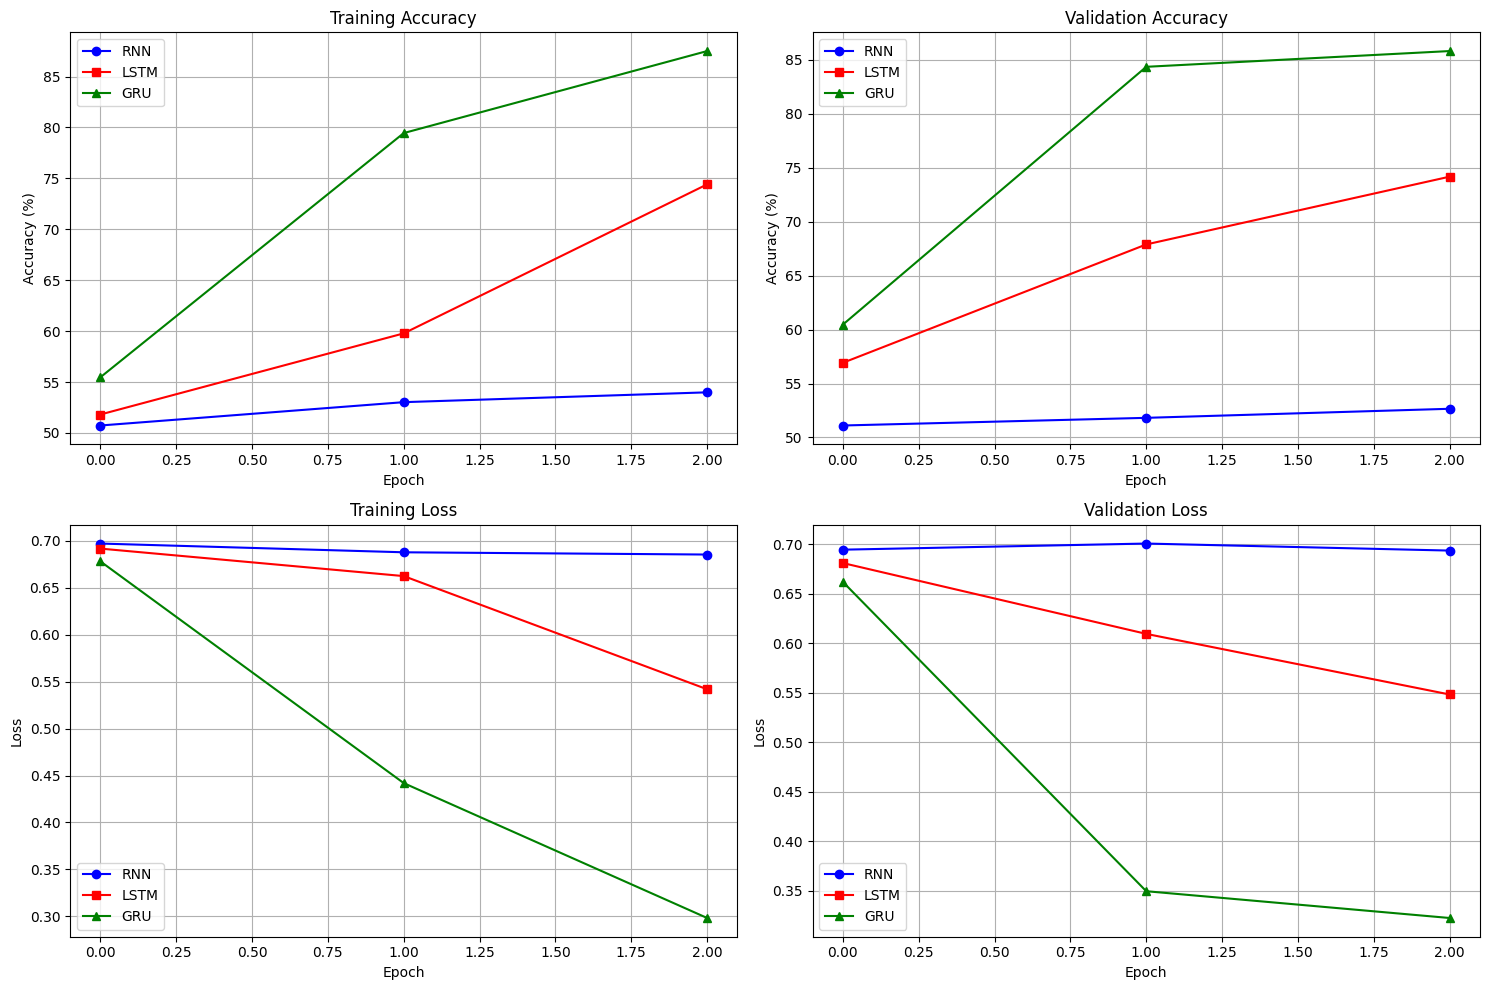

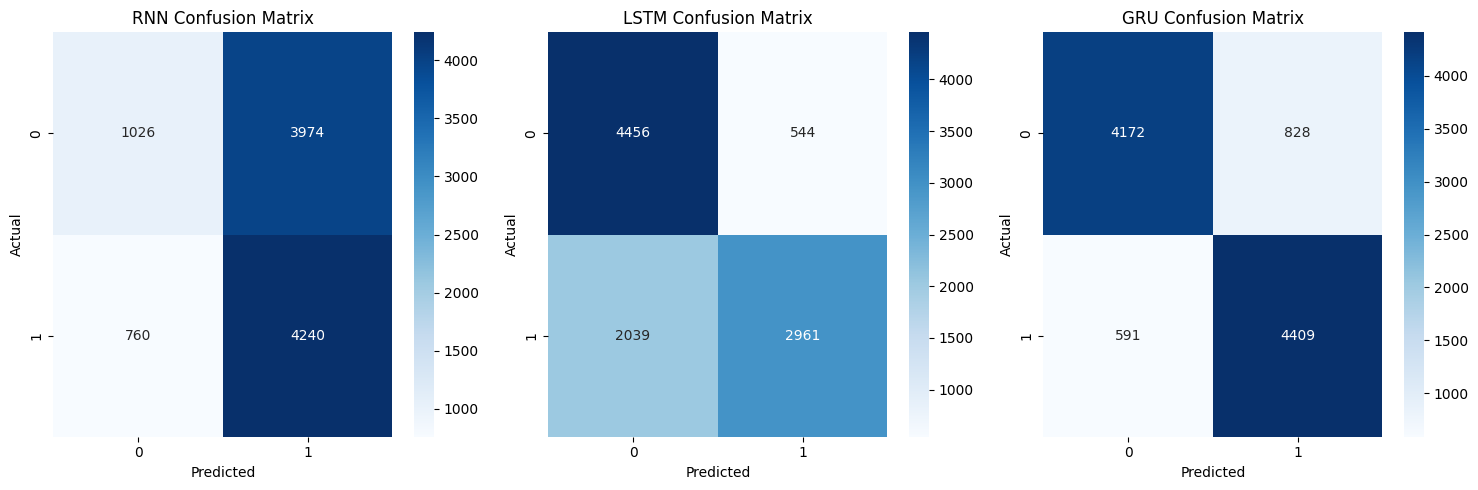


HYPERPARAMETERS USED
  - Embedding dimension: 128
  - Hidden size: 64
  - Dropout: 0.0
  - Learning rate: 0.001
  - Epochs: 3
  - Batch size: 64

SUMMARY
Best performing model: GRU
Highest accuracy: 0.8581


In [ ]:
# Base case comparison between models

model_results = {
    'RNN': rnn_results,
    'LSTM': lstm_results,
    'GRU': gru_results
}

model_histories = {
    'RNN': rnn_history,
    'LSTM': lstm_history,
    'GRU': gru_history
}

hyperparams = {
    'Embedding dimension': 128,
    'Hidden size': 64,
    'Dropout': 0.0,
    'Learning rate': 0.001,
    'Epochs': 3,
    'Batch size': 64
}

comparison_df = plot_model_comparison(
    model_results=model_results,
    model_histories=model_histories,
    hyperparams=hyperparams,
    experiment_name="Base Case - Default Hyperparameters"
)


RUNNING EXPERIMENT: LR_TEST_EMB128_HID64_DROP0.0_LR0.0001_EP3_BS64

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6994, Train Acc: 50.70%
  Val Loss: 0.6969, Val Acc: 49.96%
Epoch 2/3:
  Train Loss: 0.6938, Train Acc: 51.35%
  Val Loss: 0.6956, Val Acc: 50.61%
Epoch 3/3:
  Train Loss: 0.6912, Train Acc: 52.27%
  Val Loss: 0.6950, Val Acc: 50.53%

RNN Evaluation Results:
Accuracy: 0.5053
Precision: 0.5065
Recall: 0.5053
F1-Score: 0.4821

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6941, Train Acc: 50.21%
  Val Loss: 0.6931, Val Acc: 50.55%
Epoch 2/3:
  Train Loss: 0.6916, Train Acc: 51.90%
  Val Loss: 0.6921, Val Acc: 51.57%
Epoch 3/3:
  Train Loss: 0.6894, Train Acc: 53.22%
  Val Loss: 0.6904, Val Acc: 52.10%

LSTM Evaluation Results:
Accuracy: 0.5210
Precision: 0.5228
Recall: 0.5210
F1-Score: 0.5115

Training GRU...

Training GRU...
-------------------

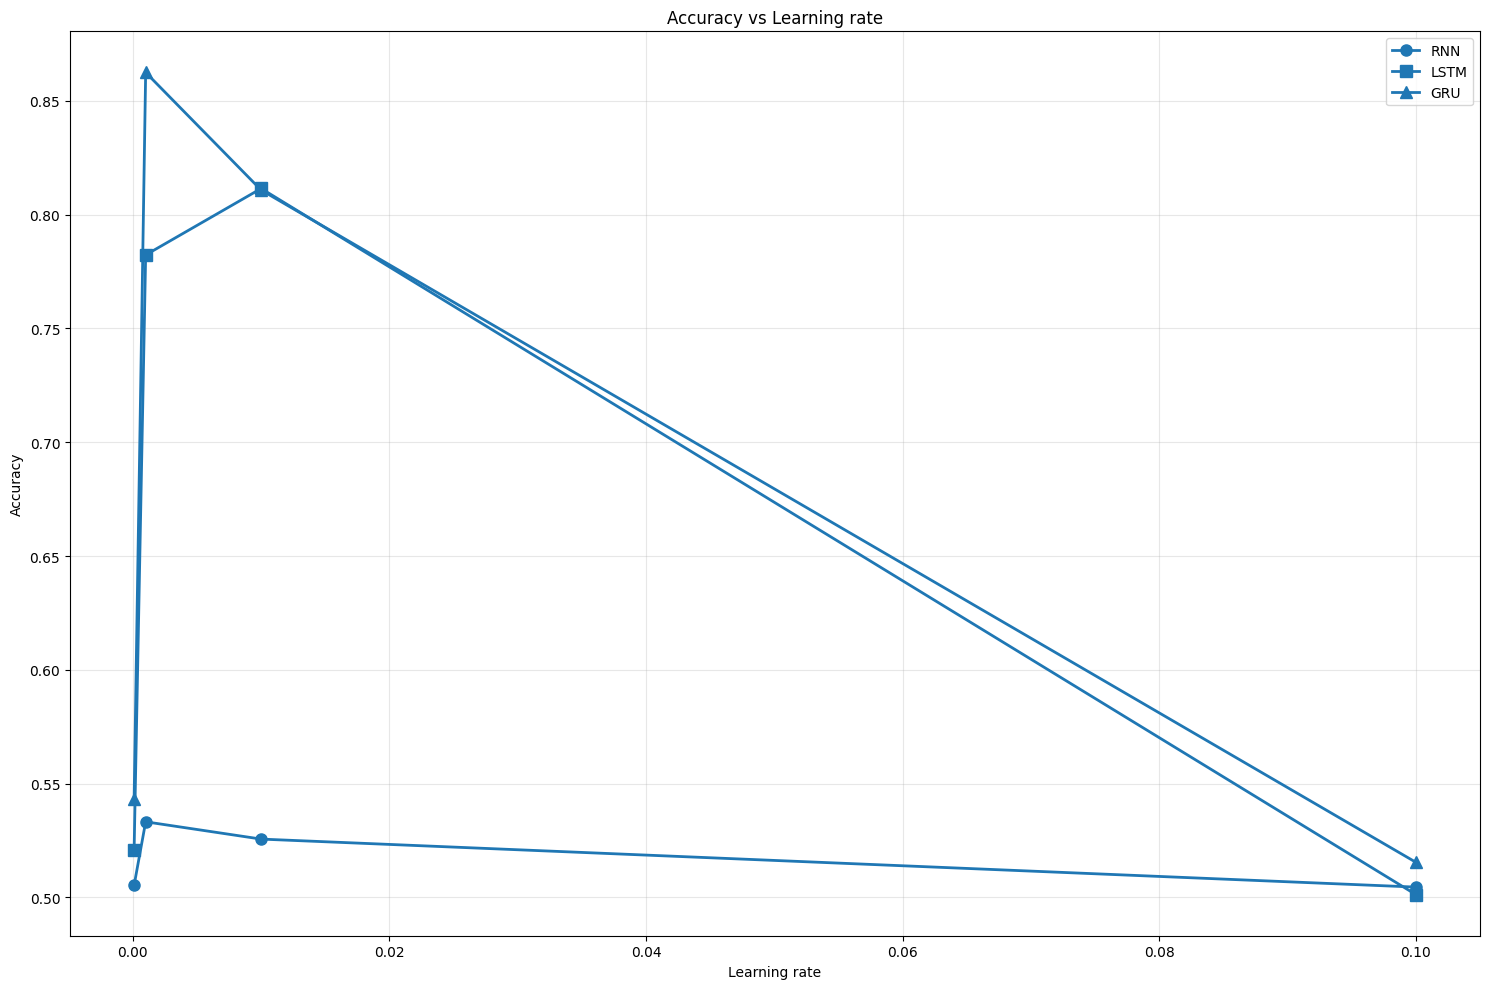


Accuracy Summary for Learning rate:
--------------------------------------------------
                        mean  std     min     max
Hyperparameter Model                             
0.0001         GRU    0.5432  NaN  0.5432  0.5432
               LSTM   0.5210  NaN  0.5210  0.5210
               RNN    0.5053  NaN  0.5053  0.5053
0.0010         GRU    0.8625  NaN  0.8625  0.8625
               LSTM   0.7823  NaN  0.7823  0.7823
               RNN    0.5332  NaN  0.5332  0.5332
0.0100         GRU    0.8108  NaN  0.8108  0.8108
               LSTM   0.8115  NaN  0.8115  0.8115
               RNN    0.5256  NaN  0.5256  0.5256
0.1000         GRU    0.5154  NaN  0.5154  0.5154
               LSTM   0.5012  NaN  0.5012  0.5012
               RNN    0.5045  NaN  0.5045  0.5045


<Figure size 1200x600 with 0 Axes>

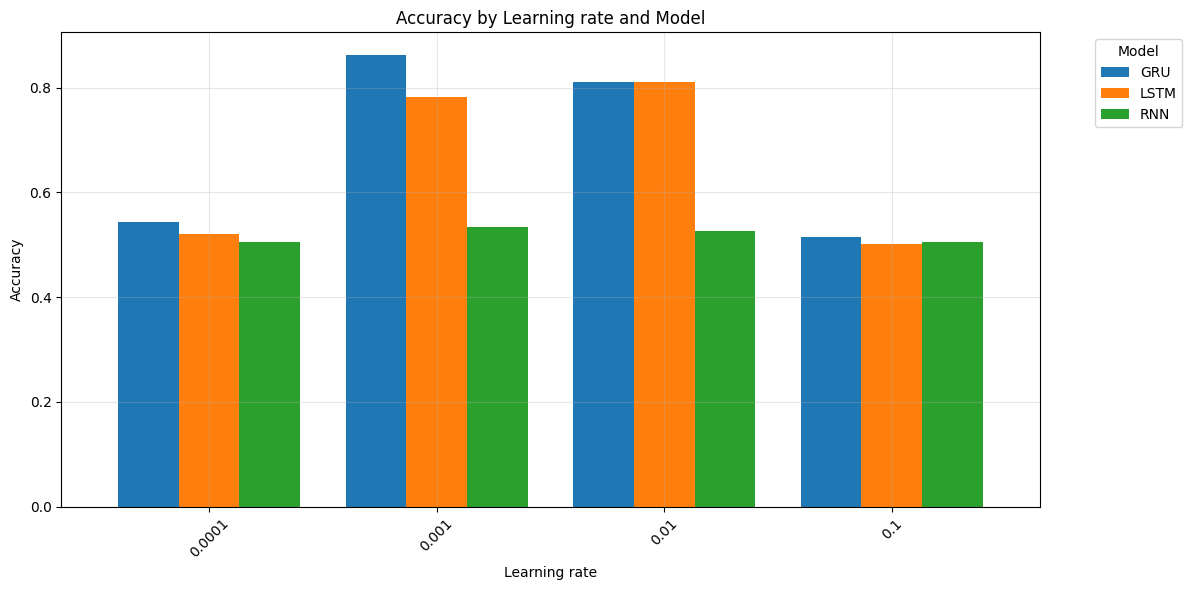


Detailed Accuracy Comparison by Learning rate:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.0001          0.5432  0.5210  0.5053
0.0010          0.8625  0.7823  0.5332
0.0100          0.8108  0.8115  0.5256
0.1000          0.5154  0.5012  0.5045


,Model,Hyperparameter,Metric
0,RNN,0.0001,0.5053
1,LSTM,0.0001,0.5210
2,GRU,0.0001,0.5432
3,RNN,0.0010,0.5332
4,LSTM,0.0010,0.7823
5,GRU,0.0010,0.8625
6,RNN,0.0100,0.5256
7,LSTM,0.0100,0.8115
8,GRU,0.0100,0.8108
9,RNN,0.1000,0.5045


In [ ]:
# Test Learning Rates

lr_experiments = run_hyperparameter_experiment(
    embedding_dim=128,
    hidden_size=64,
    dropout=0.0,
    learning_rate=[0.0001, 0.001, 0.01, 0.1],
    epochs=3,
    batch_size=64,
    experiment_name="LR_Test",
    plot_results=False
)

# plot_hyperparameter_effect(lr_experiments, 'learning_rate', metric='Accuracy', plot_type='line')
# plot_model_comparison_by_hp(lr_experiments, 'learning_rate', metric='Accuracy')


In [ ]:
epochs_experiments = run_hyperparameter_experiment(
    embedding_dim=128,
    hidden_size=64,
    dropout=0.0,
    learning_rate=0.001,
    epochs=[1, 3, 5, 10, 20],
    batch_size=64,
    experiment_name="Epochs_Test",
    plot_results=False
)


RUNNING EXPERIMENT: EPOCHS_TEST_EMB128_HID64_DROP0.0_LR0.001_EP1_BS64

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/1:
  Train Loss: 0.6973, Train Acc: 50.13%
  Val Loss: 0.6944, Val Acc: 51.38%

RNN Evaluation Results:
Accuracy: 0.5138
Precision: 0.5169
Recall: 0.5138
F1-Score: 0.4906

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/1:
  Train Loss: 0.6898, Train Acc: 52.96%
  Val Loss: 0.6843, Val Acc: 56.69%

LSTM Evaluation Results:
Accuracy: 0.5669
Precision: 0.5925
Recall: 0.5669
F1-Score: 0.5347

Training GRU...

Training GRU...
--------------------------------------------------
Epoch 1/1:
  Train Loss: 0.6843, Train Acc: 54.68%
  Val Loss: 0.6500, Val Acc: 64.99%

GRU Evaluation Results:
Accuracy: 0.6499
Precision: 0.6798
Recall: 0.6499
F1-Score: 0.6347

RUNNING EXPERIMENT: EPOCHS_TEST_EMB128_HID64_DROP0.0_LR0.001_EP3_BS64

Training RNN...

Training RNN...
-----------------------------

In [ ]:
batch_size_experiments = run_hyperparameter_experiment(
    embedding_dim=128,
    hidden_size=64,
    dropout=0.0,
    learning_rate=0.001,
    epochs=3,
    batch_size=[16, 32, 64, 128, 256],
    experiment_name="Batch_Size_Test",
    plot_results=False
)


RUNNING EXPERIMENT: BATCH_SIZE_TEST_EMB128_HID64_DROP0.0_LR0.001_EP3_BS16

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6966, Train Acc: 50.58%
  Val Loss: 0.6900, Val Acc: 52.15%
Epoch 2/3:
  Train Loss: 0.6891, Train Acc: 53.62%
  Val Loss: 0.6944, Val Acc: 51.23%
Epoch 3/3:
  Train Loss: 0.6794, Train Acc: 55.84%
  Val Loss: 0.6970, Val Acc: 50.34%

RNN Evaluation Results:
Accuracy: 0.5034
Precision: 0.5143
Recall: 0.5034
F1-Score: 0.3864

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6821, Train Acc: 54.78%
  Val Loss: 0.6809, Val Acc: 61.15%
Epoch 2/3:
  Train Loss: 0.5871, Train Acc: 70.14%
  Val Loss: 0.6068, Val Acc: 67.98%
Epoch 3/3:
  Train Loss: 0.4556, Train Acc: 79.34%
  Val Loss: 0.4009, Val Acc: 82.17%

LSTM Evaluation Results:
Accuracy: 0.8217
Precision: 0.8219
Recall: 0.8217
F1-Score: 0.8217

Training GRU...

Training GRU...
------------

In [ ]:
hidden_size_experiments = run_hyperparameter_experiment(
    embedding_dim=128,
    hidden_size=[16, 32, 64, 128, 256],
    dropout=0.0,
    learning_rate=0.001,
    epochs=3,
    batch_size=64,
    experiment_name="Hidden_Size_Test",
    plot_results=False
)


RUNNING EXPERIMENT: HIDDEN_SIZE_TEST_EMB128_HID16_DROP0.0_LR0.001_EP3_BS64

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6987, Train Acc: 50.72%
  Val Loss: 0.6930, Val Acc: 50.62%
Epoch 2/3:
  Train Loss: 0.6894, Train Acc: 52.55%
  Val Loss: 0.6935, Val Acc: 50.54%
Epoch 3/3:
  Train Loss: 0.6826, Train Acc: 54.20%
  Val Loss: 0.6972, Val Acc: 51.66%

RNN Evaluation Results:
Accuracy: 0.5166
Precision: 0.5219
Recall: 0.5166
F1-Score: 0.4855

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6927, Train Acc: 51.01%
  Val Loss: 0.6911, Val Acc: 52.13%
Epoch 2/3:
  Train Loss: 0.6644, Train Acc: 59.00%
  Val Loss: 0.6146, Val Acc: 69.03%
Epoch 3/3:
  Train Loss: 0.5830, Train Acc: 70.69%
  Val Loss: 0.5510, Val Acc: 73.90%

LSTM Evaluation Results:
Accuracy: 0.7390
Precision: 0.7403
Recall: 0.7390
F1-Score: 0.7386

Training GRU...

Training GRU...
-----------

In [ ]:
dropout_experiments = run_hyperparameter_experiment(
    embedding_dim=128,
    hidden_size=64,
    dropout=[0.0, 0.2, 0.4, 0.6],
    learning_rate=0.001,
    epochs=3,
    batch_size=64,
    experiment_name="Dropout_Test",
    plot_results=False
)


RUNNING EXPERIMENT: DROPOUT_TEST_EMB128_HID64_DROP0.0_LR0.001_EP3_BS64

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6982, Train Acc: 50.27%
  Val Loss: 0.6936, Val Acc: 51.16%
Epoch 2/3:
  Train Loss: 0.6888, Train Acc: 53.31%
  Val Loss: 0.6918, Val Acc: 52.06%
Epoch 3/3:
  Train Loss: 0.6848, Train Acc: 53.95%
  Val Loss: 0.6898, Val Acc: 53.38%

RNN Evaluation Results:
Accuracy: 0.5338
Precision: 0.5399
Recall: 0.5338
F1-Score: 0.5153

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6824, Train Acc: 55.37%
  Val Loss: 0.6960, Val Acc: 49.73%
Epoch 2/3:
  Train Loss: 0.6916, Train Acc: 51.69%
  Val Loss: 0.6921, Val Acc: 52.49%
Epoch 3/3:
  Train Loss: 0.6646, Train Acc: 57.90%
  Val Loss: 0.5184, Val Acc: 76.46%

LSTM Evaluation Results:
Accuracy: 0.7646
Precision: 0.7647
Recall: 0.7646
F1-Score: 0.7646

Training GRU...

Training GRU...
---------------

In [ ]:
embedding_dim_experiments = run_hyperparameter_experiment(
    embedding_dim=[16, 32, 64, 128, 256],
    hidden_size=64,
    dropout=0.0,
    learning_rate=0.001,
    epochs=3,
    batch_size=64,
    experiment_name="Embedding_Dim_Test",
    plot_results=False
)


RUNNING EXPERIMENT: EMBEDDING_DIM_TEST_EMB16_HID64_DROP0.0_LR0.001_EP3_BS64

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6950, Train Acc: 50.20%
  Val Loss: 0.6931, Val Acc: 50.74%
Epoch 2/3:
  Train Loss: 0.6927, Train Acc: 51.55%
  Val Loss: 0.6931, Val Acc: 52.26%
Epoch 3/3:
  Train Loss: 0.6901, Train Acc: 52.71%
  Val Loss: 0.6950, Val Acc: 52.95%

RNN Evaluation Results:
Accuracy: 0.5295
Precision: 0.5324
Recall: 0.5295
F1-Score: 0.5189

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6932, Train Acc: 50.76%
  Val Loss: 0.6880, Val Acc: 54.28%
Epoch 2/3:
  Train Loss: 0.6923, Train Acc: 51.19%
  Val Loss: 0.6855, Val Acc: 53.86%
Epoch 3/3:
  Train Loss: 0.6912, Train Acc: 52.06%
  Val Loss: 0.6901, Val Acc: 52.50%

LSTM Evaluation Results:
Accuracy: 0.5250
Precision: 0.5323
Recall: 0.5250
F1-Score: 0.4966

Training GRU...

Training GRU...
----------

In [52]:
loss_function_experiments = run_hyperparameter_experiment(
    embedding_dim=128,
    hidden_size=64,
    dropout=0.0,
    learning_rate=0.01,
    epochs=1,
    batch_size=64,
    loss_function=['CrossEntropyLoss', 'MSELoss', 'NLLLoss'],
    experiment_name="Loss_Function_Test",
    plot_results=False
)


RUNNING EXPERIMENT: LOSS_FUNCTION_TEST_EMB128_HID64_DROP0.0_LR0.01_EP1_BS64_LOSSCROSSENTROPYLOSS_NOCLIP_OPTADAM

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/1:
  Train Loss: 0.7100, Train Acc: 50.21%
  Val Loss: 0.7066, Val Acc: 50.30%

RNN Evaluation Results:
Accuracy: 0.5030
Precision: 0.5051
Recall: 0.5030
F1-Score: 0.4458

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/1:
  Train Loss: 0.6756, Train Acc: 56.05%
  Val Loss: 0.6365, Val Acc: 67.78%

LSTM Evaluation Results:
Accuracy: 0.6778
Precision: 0.6811
Recall: 0.6778
F1-Score: 0.6763

Training GRU...

Training GRU...
--------------------------------------------------
Epoch 1/1:
  Train Loss: 0.5267, Train Acc: 71.92%
  Val Loss: 0.4141, Val Acc: 80.71%

GRU Evaluation Results:
Accuracy: 0.8071
Precision: 0.8098
Recall: 0.8071
F1-Score: 0.8067

RUNNING EXPERIMENT: LOSS_FUNCTION_TEST_EMB128_HID64_DROP0.0_LR0.01_EP1_BS64_LOSSMSELOSS_NOC

In [44]:
gradient_clipping_experiments = run_hyperparameter_experiment(
    embedding_dim=128,
    hidden_size=64,
    dropout=0.0,
    learning_rate=0.01,
    epochs=1,
    batch_size=64,
    gradient_clip=[None, 0.1, 0.5, 1.0],
    gradient_clip_type=['norm', 'value'],
    experiment_name="Gradient_Clipping_Test",
    plot_results=False
)


RUNNING EXPERIMENT: GRADIENT_CLIPPING_TEST_EMB128_HID64_DROP0.0_LR0.01_EP1_BS64_LOSSCROSSENTROPYLOSS_NOCLIP_OPTADAM

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/1:
  Train Loss: 0.7105, Train Acc: 50.09%
  Val Loss: 0.6948, Val Acc: 51.13%

RNN Evaluation Results:
Accuracy: 0.5113
Precision: 0.5148
Recall: 0.5113
F1-Score: 0.4809

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/1:
  Train Loss: 0.6918, Train Acc: 52.88%
  Val Loss: 0.6171, Val Acc: 66.26%

LSTM Evaluation Results:
Accuracy: 0.6626
Precision: 0.6909
Recall: 0.6626
F1-Score: 0.6496

Training GRU...

Training GRU...
--------------------------------------------------
Epoch 1/1:
  Train Loss: 0.5178, Train Acc: 72.24%
  Val Loss: 0.4045, Val Acc: 82.17%

GRU Evaluation Results:
Accuracy: 0.8217
Precision: 0.8253
Recall: 0.8217
F1-Score: 0.8212

RUNNING EXPERIMENT: GRADIENT_CLIPPING_TEST_EMB128_HID64_DROP0.0_LR0.01_EP1_BS64_LOSSCRO

In [47]:
gradient_clipping_value_test = run_hyperparameter_experiment(
    embedding_dim=128,
    hidden_size=64,
    dropout=0.0,
    learning_rate=0.01,
    epochs=1,
    batch_size=64,
    gradient_clip=[None, 0.1, 0.5, 1.0],
    gradient_clip_type='value',
    experiment_name="Gradient_Clipping_Value_Test",
    plot_results=False
)


RUNNING EXPERIMENT: GRADIENT_CLIPPING_VALUE_TEST_EMB128_HID64_DROP0.0_LR0.01_EP1_BS64_LOSSCROSSENTROPYLOSS_NOCLIP_OPTADAM

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/1:
  Train Loss: 0.7099, Train Acc: 50.08%
  Val Loss: 0.7225, Val Acc: 51.35%

RNN Evaluation Results:
Accuracy: 0.5135
Precision: 0.5242
Recall: 0.5135
F1-Score: 0.4532

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/1:
  Train Loss: 0.6761, Train Acc: 56.13%
  Val Loss: 0.6051, Val Acc: 68.48%

LSTM Evaluation Results:
Accuracy: 0.6848
Precision: 0.6852
Recall: 0.6848
F1-Score: 0.6846

Training GRU...

Training GRU...
--------------------------------------------------
Epoch 1/1:
  Train Loss: 0.5049, Train Acc: 72.76%
  Val Loss: 0.3802, Val Acc: 82.71%

GRU Evaluation Results:
Accuracy: 0.8271
Precision: 0.8272
Recall: 0.8271
F1-Score: 0.8271

RUNNING EXPERIMENT: GRADIENT_CLIPPING_VALUE_TEST_EMB128_HID64_DROP0.0_LR0.01_EP1_

In [46]:
gradient_clipping_norm_test = run_hyperparameter_experiment(
    embedding_dim=128,
    hidden_size=64,
    dropout=0.0,
    learning_rate=0.01,
    epochs=1,
    batch_size=64,
    gradient_clip=[None, 0.1, 0.5, 1.0],
    gradient_clip_type='norm',
    experiment_name="Gradient_Clipping_Norm_Test",
    plot_results=False
)


RUNNING EXPERIMENT: GRADIENT_CLIPPING_NORM_TEST_EMB128_HID64_DROP0.0_LR0.01_EP1_BS64_LOSSCROSSENTROPYLOSS_NOCLIP_OPTADAM

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/1:
  Train Loss: 0.7087, Train Acc: 50.84%
  Val Loss: 0.7187, Val Acc: 49.50%

RNN Evaluation Results:
Accuracy: 0.4950
Precision: 0.4914
Recall: 0.4950
F1-Score: 0.4365

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/1:
  Train Loss: 0.6797, Train Acc: 55.32%
  Val Loss: 0.5750, Val Acc: 71.43%

LSTM Evaluation Results:
Accuracy: 0.7143
Precision: 0.7152
Recall: 0.7143
F1-Score: 0.7140

Training GRU...

Training GRU...
--------------------------------------------------
Epoch 1/1:
  Train Loss: 0.5318, Train Acc: 72.28%
  Val Loss: 0.4114, Val Acc: 81.71%

GRU Evaluation Results:
Accuracy: 0.8171
Precision: 0.8171
Recall: 0.8171
F1-Score: 0.8171

RUNNING EXPERIMENT: GRADIENT_CLIPPING_NORM_TEST_EMB128_HID64_DROP0.0_LR0.01_EP1_BS

### Plots by hyperparameter (Accuracy + F1)

<Figure size 1200x600 with 0 Axes>

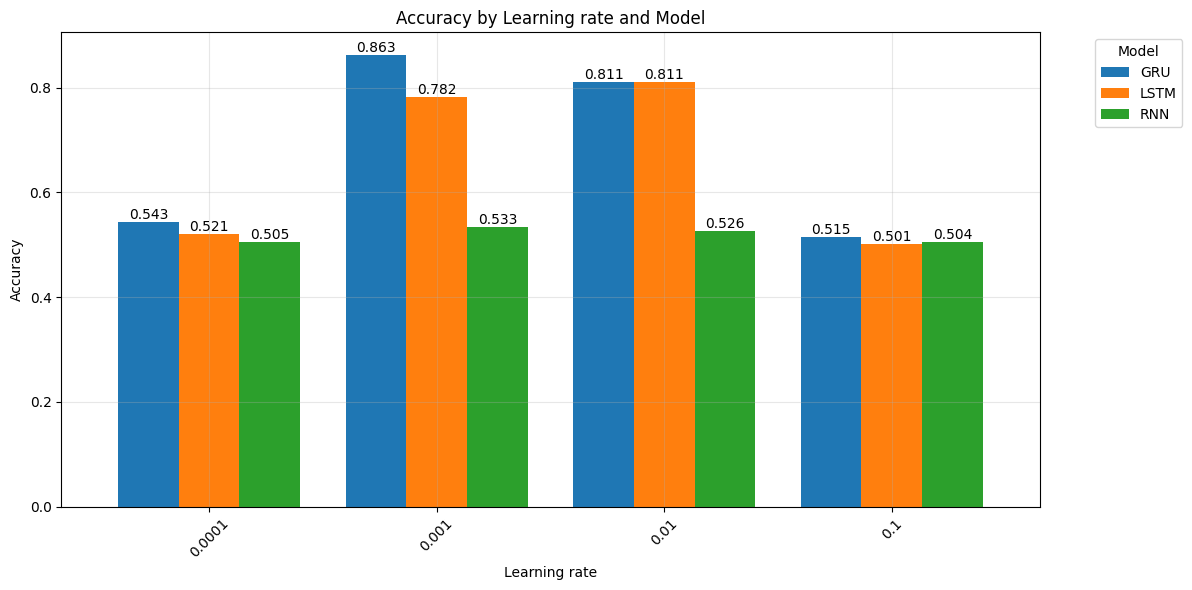


Detailed Accuracy Comparison by Learning rate:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.0001          0.5432  0.5210  0.5053
0.0010          0.8625  0.7823  0.5332
0.0100          0.8108  0.8115  0.5256
0.1000          0.5154  0.5012  0.5045


<Figure size 1200x600 with 0 Axes>

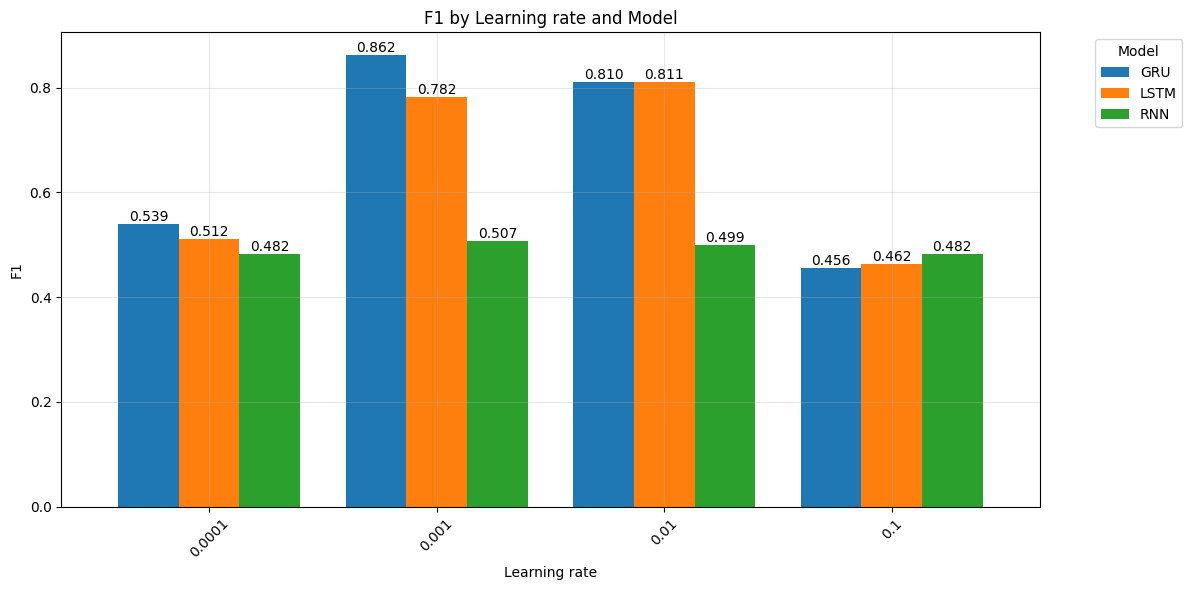


Detailed F1 Comparison by Learning rate:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.0001          0.5392  0.5115  0.4821
0.0010          0.8625  0.7823  0.5073
0.0100          0.8105  0.8113  0.4993
0.1000          0.4555  0.4624  0.4818


,Model,Hyperparameter,Metric
0,RNN,0.0001,0.482089
1,LSTM,0.0001,0.511535
2,GRU,0.0001,0.539215
3,RNN,0.0010,0.507318
4,LSTM,0.0010,0.782300
5,GRU,0.0010,0.862476
6,RNN,0.0100,0.499297
7,LSTM,0.0100,0.811310
8,GRU,0.0100,0.810491
9,RNN,0.1000,0.481845


In [ ]:
plot_model_comparison_by_hp(lr_experiments, 'learning_rate', metric='Accuracy')
plot_model_comparison_by_hp(lr_experiments, 'learning_rate', metric='F1')

<Figure size 1200x600 with 0 Axes>

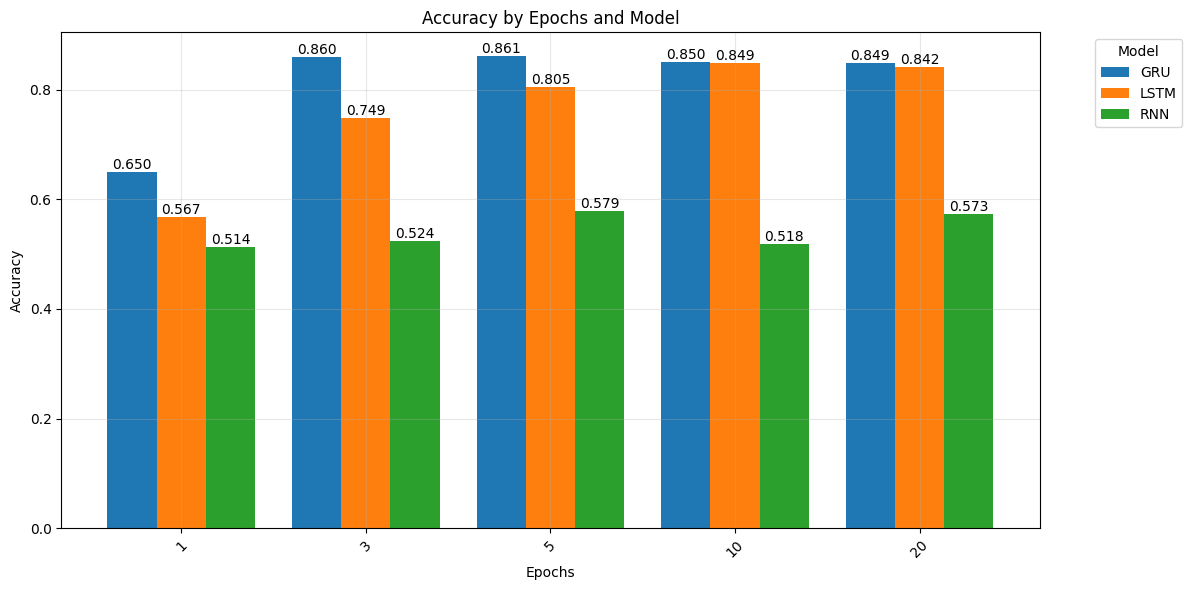


Detailed Accuracy Comparison by Epochs:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
1               0.6499  0.5669  0.5138
3               0.8598  0.7487  0.5242
5               0.8614  0.8054  0.5794
10              0.8495  0.8485  0.5181
20              0.8486  0.8415  0.5728


<Figure size 1200x600 with 0 Axes>

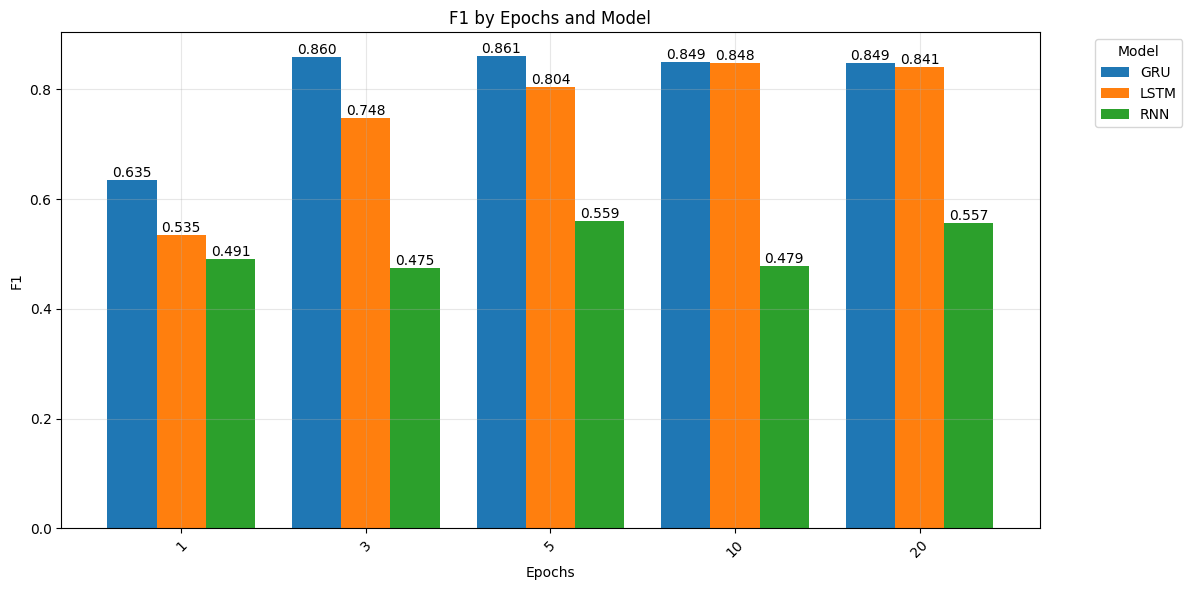


Detailed F1 Comparison by Epochs:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
1               0.6347  0.5347  0.4906
3               0.8597  0.7476  0.4747
5               0.8611  0.8044  0.5594
10              0.8495  0.8485  0.4785
20              0.8486  0.8415  0.5574


,Model,Hyperparameter,Metric
0,RNN,1,0.490602
1,LSTM,1,0.534691
2,GRU,1,0.634713
3,RNN,3,0.474690
4,LSTM,3,0.747584
5,GRU,3,0.859744
6,RNN,5,0.559372
7,LSTM,5,0.804375
8,GRU,5,0.861136
9,RNN,10,0.478519


In [ ]:
plot_model_comparison_by_hp(epochs_experiments, 'epochs', metric='Accuracy')
plot_model_comparison_by_hp(epochs_experiments, 'epochs', metric='F1')

<Figure size 1200x600 with 0 Axes>

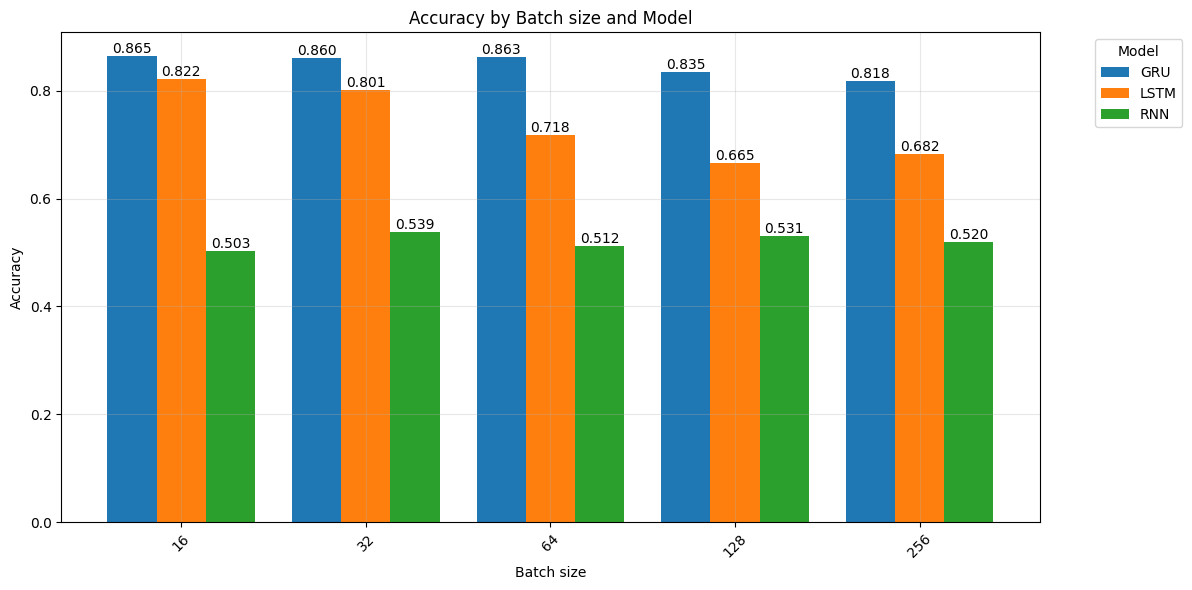


Detailed Accuracy Comparison by Batch size:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
16              0.8649  0.8217  0.5034
32              0.8602  0.8008  0.5386
64              0.8625  0.7184  0.5124
128             0.8350  0.6652  0.5311
256             0.8183  0.6824  0.5197


<Figure size 1200x600 with 0 Axes>

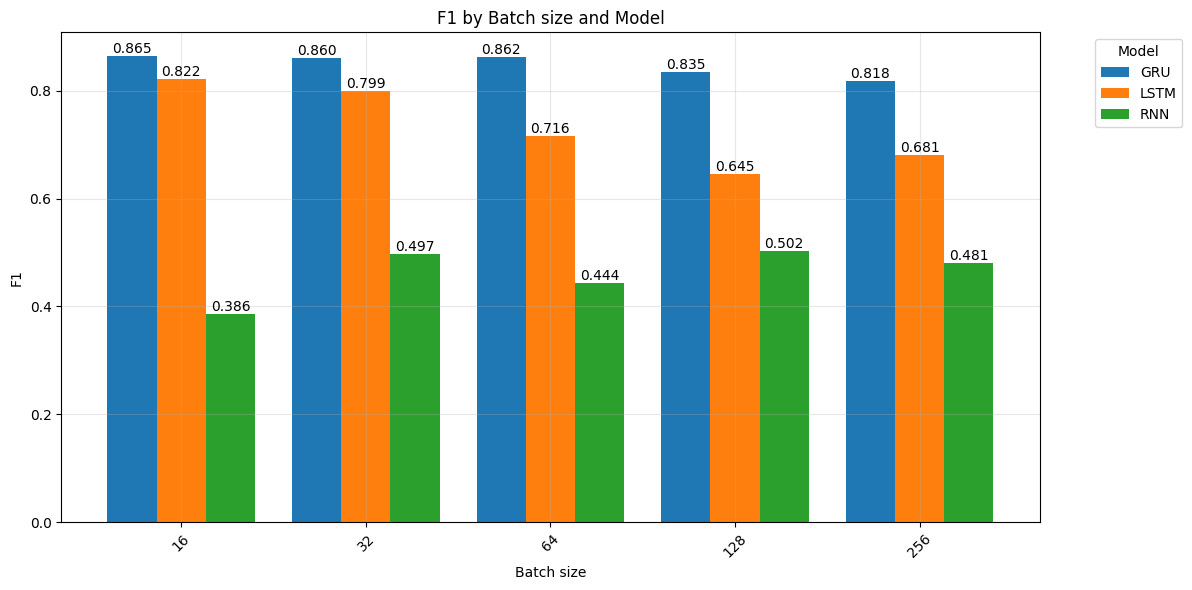


Detailed F1 Comparison by Batch size:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
16              0.8649  0.8217  0.3864
32              0.8601  0.7988  0.4968
64              0.8625  0.7158  0.4442
128             0.8350  0.6454  0.5019
256             0.8182  0.6811  0.4813


,Model,Hyperparameter,Metric
0,RNN,16,0.386444
1,LSTM,16,0.821666
2,GRU,16,0.864894
3,RNN,32,0.496805
4,LSTM,32,0.798820
5,GRU,32,0.860146
6,RNN,64,0.444242
7,LSTM,64,0.715759
8,GRU,64,0.862497
9,RNN,128,0.501854


In [69]:
plot_model_comparison_by_hp(batch_size_experiments, 'batch_size', metric='Accuracy')
plot_model_comparison_by_hp(batch_size_experiments, 'batch_size', metric='F1')

(Hidden layers number not so important)

<Figure size 1200x600 with 0 Axes>

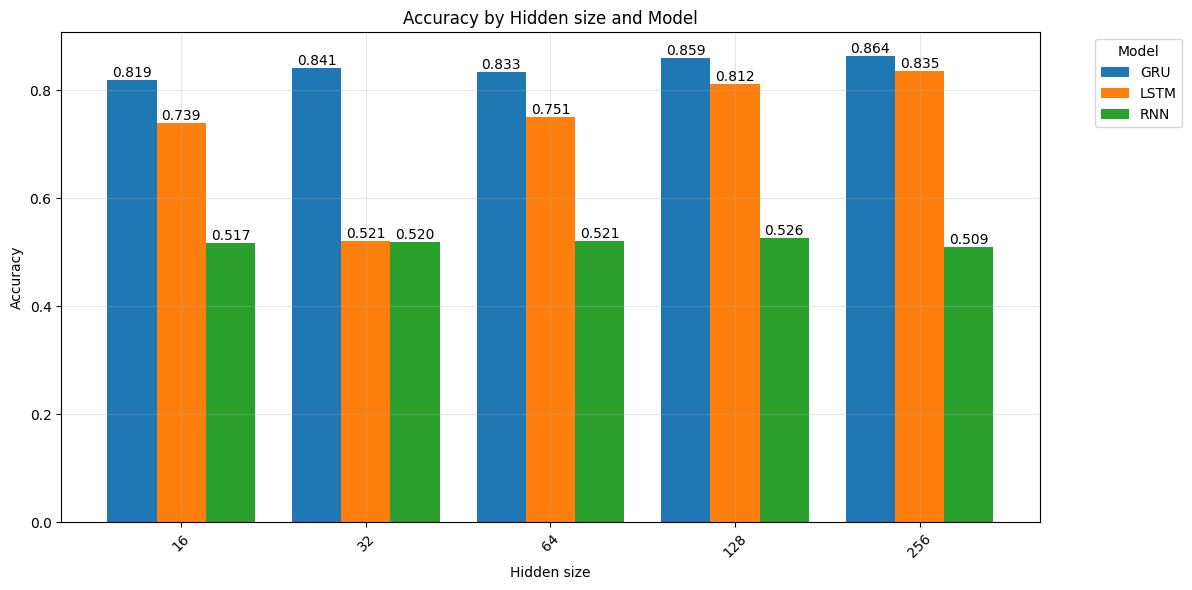


Detailed Accuracy Comparison by Hidden size:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
16              0.8193  0.7390  0.5166
32              0.8407  0.5209  0.5197
64              0.8331  0.7514  0.5209
128             0.8592  0.8119  0.5264
256             0.8643  0.8350  0.5089


<Figure size 1200x600 with 0 Axes>

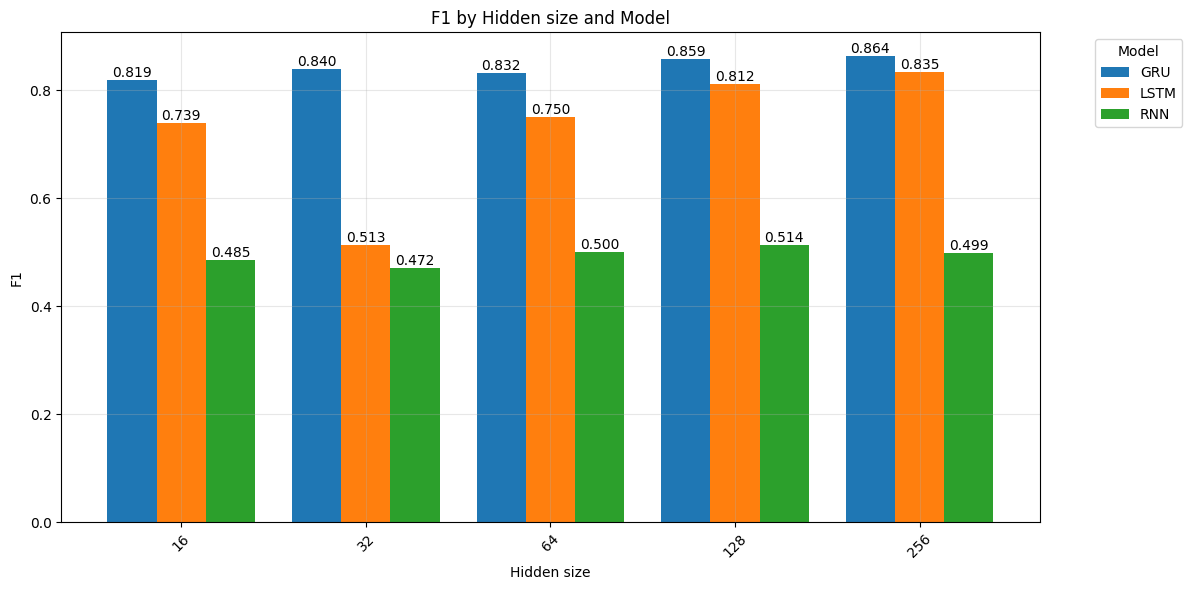


Detailed F1 Comparison by Hidden size:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
16              0.8189  0.7386  0.4855
32              0.8404  0.5133  0.4716
64              0.8316  0.7502  0.5001
128             0.8590  0.8116  0.5138
256             0.8643  0.8346  0.4989


,Model,Hyperparameter,Metric
0,RNN,16,0.485462
1,LSTM,16,0.738634
2,GRU,16,0.818884
3,RNN,32,0.471604
4,LSTM,32,0.513308
5,GRU,32,0.840417
6,RNN,64,0.500075
7,LSTM,64,0.750218
8,GRU,64,0.831628
9,RNN,128,0.513765


In [70]:
plot_model_comparison_by_hp(hidden_size_experiments, 'hidden_size', metric='Accuracy')
plot_model_comparison_by_hp(hidden_size_experiments, 'hidden_size', metric='F1')

<Figure size 1200x600 with 0 Axes>

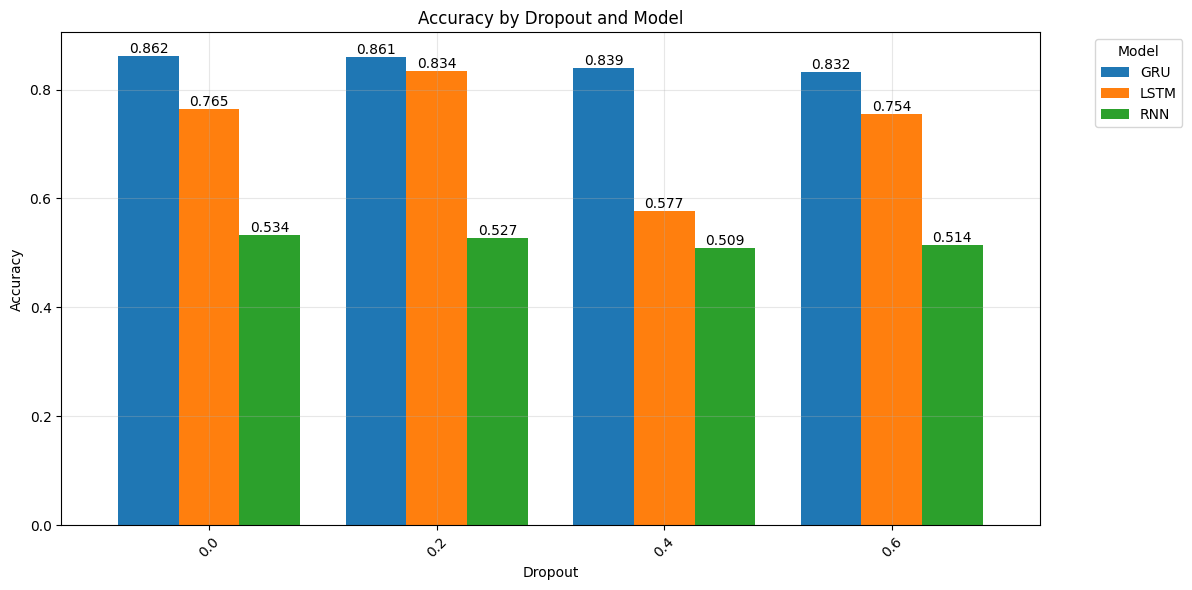


Detailed Accuracy Comparison by Dropout:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.0             0.8620  0.7646  0.5338
0.2             0.8606  0.8342  0.5272
0.4             0.8393  0.5772  0.5088
0.6             0.8315  0.7543  0.5141


<Figure size 1200x600 with 0 Axes>

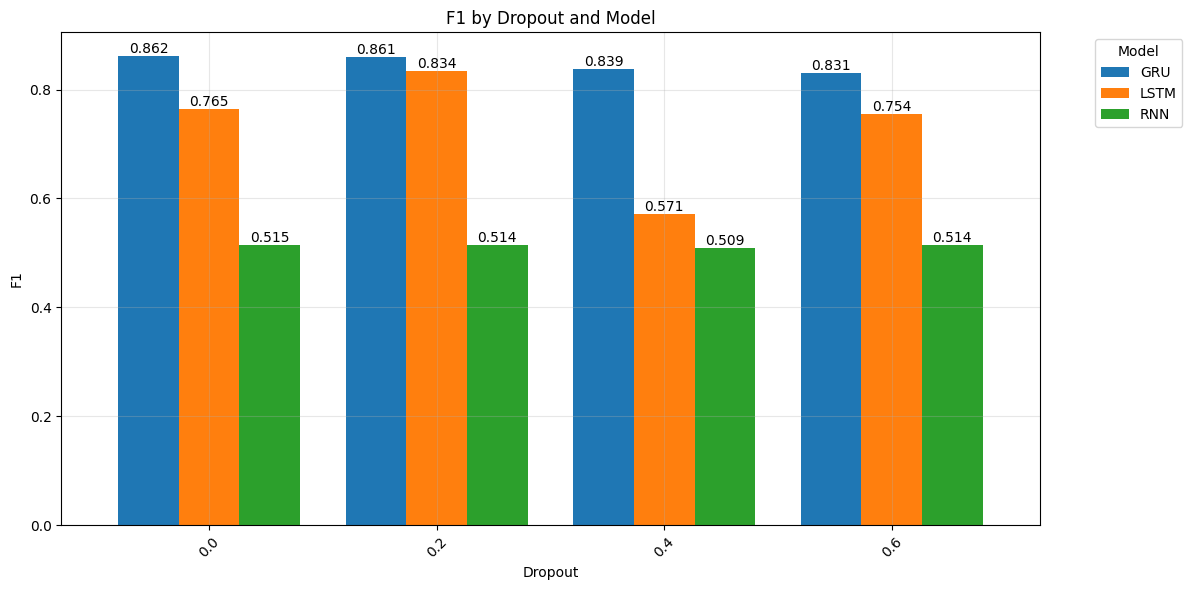


Detailed F1 Comparison by Dropout:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.0             0.8619  0.7646  0.5153
0.2             0.8605  0.8339  0.5144
0.4             0.8386  0.5713  0.5085
0.6             0.8305  0.7543  0.5137


,Model,Hyperparameter,Metric
0,RNN,0.0,0.515333
1,LSTM,0.0,0.764580
2,GRU,0.0,0.861937
3,RNN,0.2,0.514425
4,LSTM,0.2,0.833934
5,GRU,0.2,0.860531
6,RNN,0.4,0.508503
7,LSTM,0.4,0.571291
8,GRU,0.4,0.838616
9,RNN,0.6,0.513727


In [71]:
plot_model_comparison_by_hp(dropout_experiments, 'dropout', metric='Accuracy')
plot_model_comparison_by_hp(dropout_experiments, 'dropout', metric='F1')

<Figure size 1200x600 with 0 Axes>

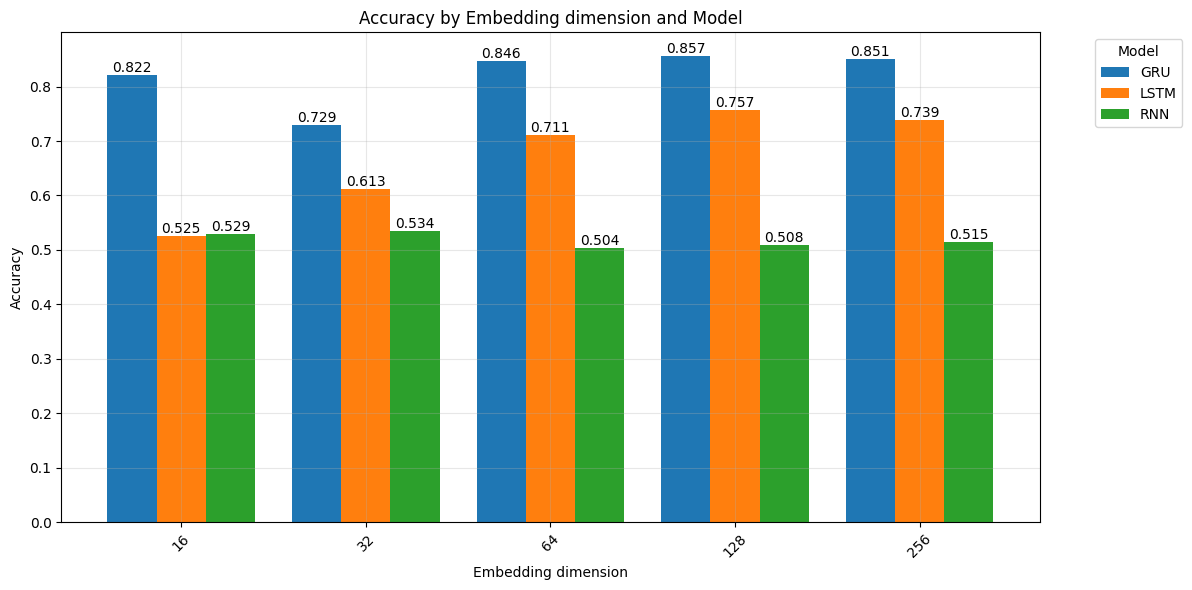


Detailed Accuracy Comparison by Embedding dimension:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
16              0.8221  0.5250  0.5295
32              0.7289  0.6125  0.5341
64              0.8464  0.7110  0.5039
128             0.8568  0.7572  0.5082
256             0.8513  0.7389  0.5146


<Figure size 1200x600 with 0 Axes>

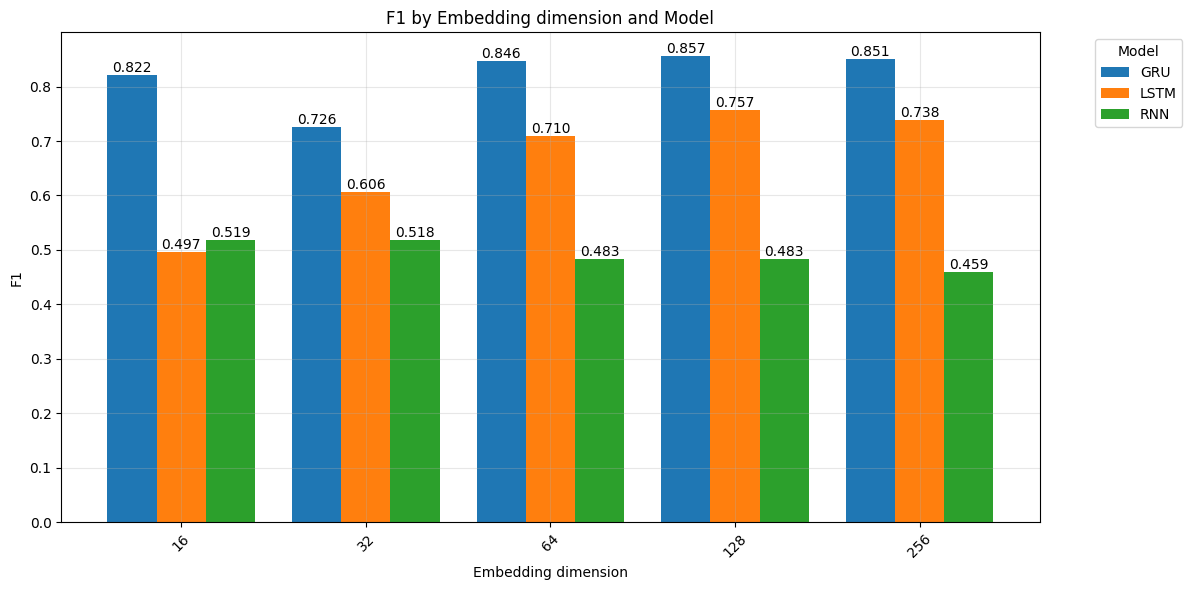


Detailed F1 Comparison by Embedding dimension:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
16              0.8220  0.4966  0.5189
32              0.7259  0.6057  0.5179
64              0.8464  0.7101  0.4831
128             0.8568  0.7572  0.4826
256             0.8512  0.7378  0.4594


,Model,Hyperparameter,Metric
0,RNN,16,0.518861
1,LSTM,16,0.496631
2,GRU,16,0.821957
3,RNN,32,0.517902
4,LSTM,32,0.605702
5,GRU,32,0.725930
6,RNN,64,0.483121
7,LSTM,64,0.710058
8,GRU,64,0.846400
9,RNN,128,0.482609


In [ ]:
plot_model_comparison_by_hp(embedding_dim_experiments, 'embedding_dim', metric='Accuracy')
plot_model_comparison_by_hp(embedding_dim_experiments, 'embedding_dim', metric='F1')

<Figure size 1200x600 with 0 Axes>

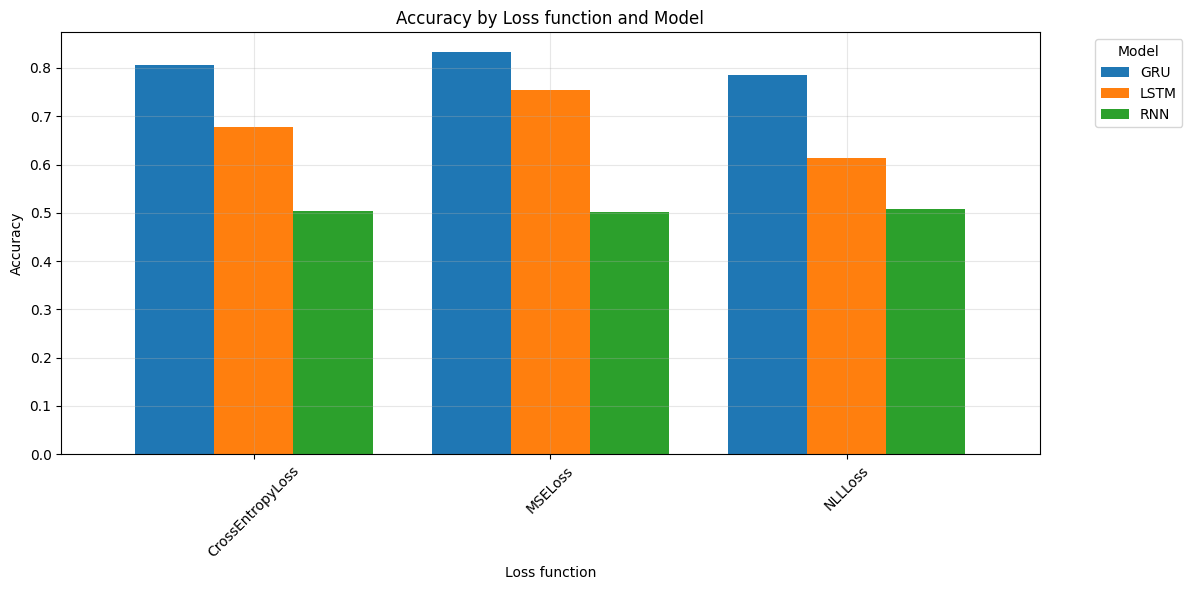


Detailed Accuracy Comparison by Loss function:
------------------------------------------------------------
Model                GRU    LSTM     RNN
Hyperparameter                          
CrossEntropyLoss  0.8071  0.6778  0.5030
MSELoss           0.8321  0.7533  0.5010
NLLLoss           0.7850  0.6142  0.5074


<Figure size 1200x600 with 0 Axes>

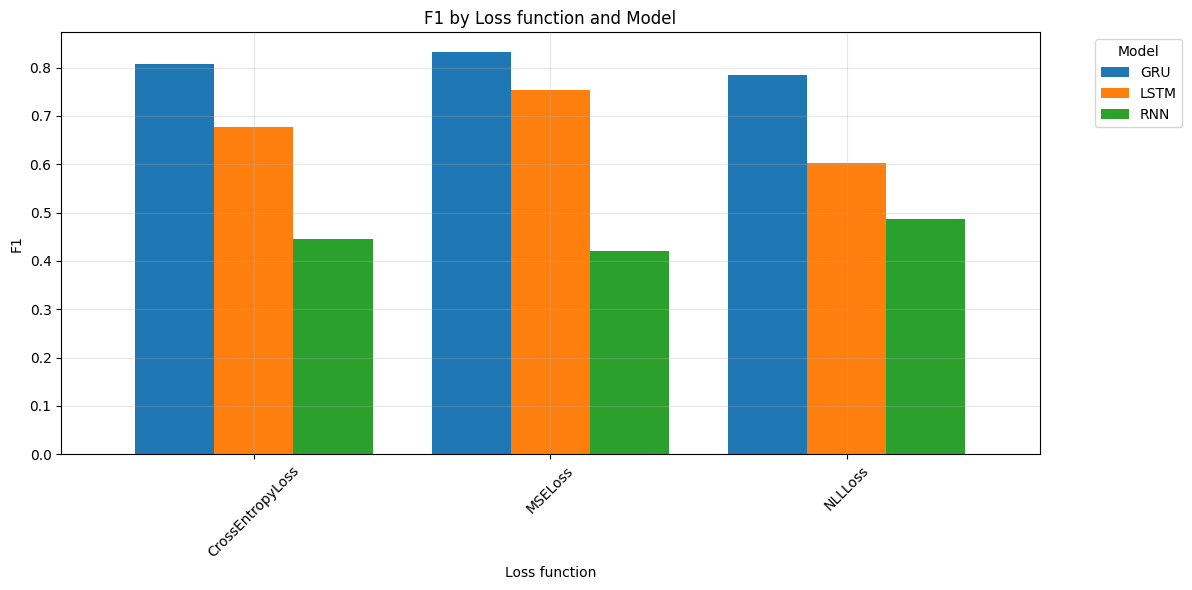


Detailed F1 Comparison by Loss function:
------------------------------------------------------------
Model                GRU    LSTM     RNN
Hyperparameter                          
CrossEntropyLoss  0.8067  0.6763  0.4458
MSELoss           0.8312  0.7532  0.4208
NLLLoss           0.7846  0.6019  0.4857


,Hyperparameter,Model,Metric
0,CrossEntropyLoss,GRU,0.806686
1,CrossEntropyLoss,LSTM,0.676321
2,CrossEntropyLoss,RNN,0.445826
3,MSELoss,GRU,0.831198
4,MSELoss,LSTM,0.753177
5,MSELoss,RNN,0.420756
6,NLLLoss,GRU,0.784649
7,NLLLoss,LSTM,0.601925
8,NLLLoss,RNN,0.485702


In [53]:
plot_model_comparison_by_hp(loss_function_experiments, 'loss_function', metric='Accuracy')
plot_model_comparison_by_hp(loss_function_experiments, 'loss_function', metric='F1')

<Figure size 1200x600 with 0 Axes>

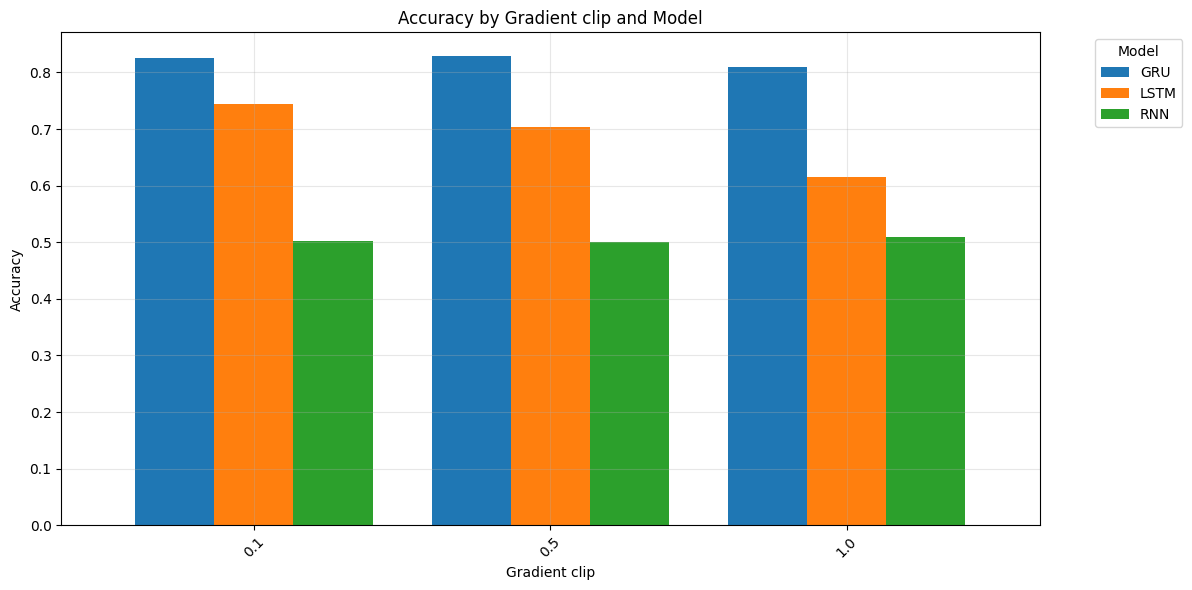


Detailed Accuracy Comparison by Gradient clip:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.1             0.8252  0.7444  0.5020
0.5             0.8294  0.7042  0.5007
1.0             0.8096  0.6159  0.5092


<Figure size 1200x600 with 0 Axes>

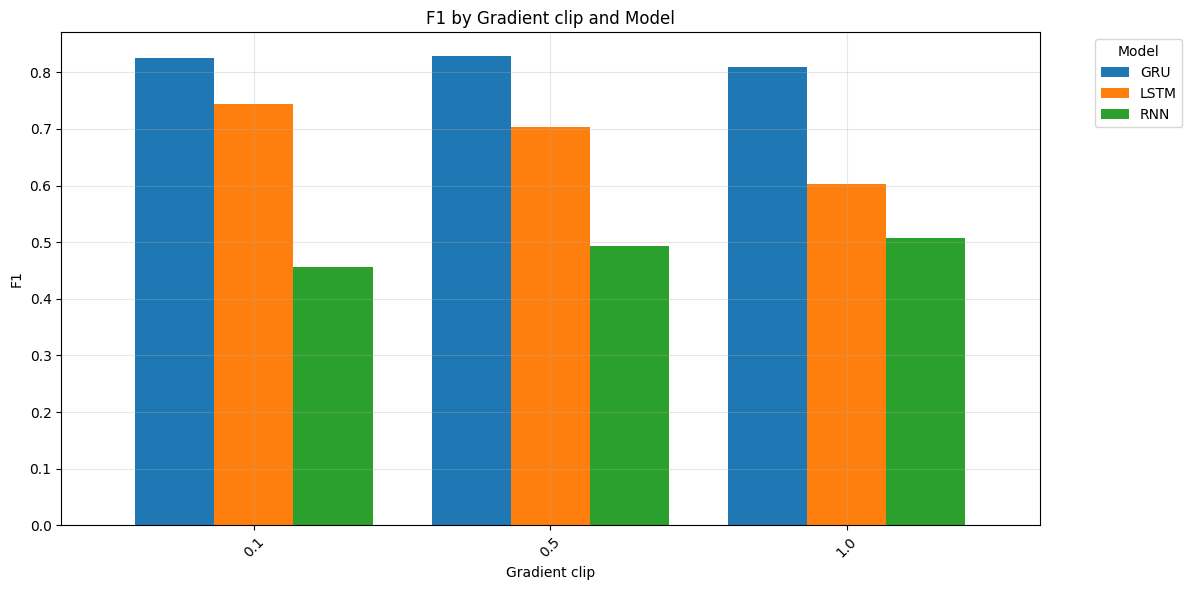


Detailed F1 Comparison by Gradient clip:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.1             0.8252  0.7444  0.4562
0.5             0.8292  0.7042  0.4928
1.0             0.8096  0.6022  0.5077


,Hyperparameter,Model,Metric
0,0.1,GRU,0.825198
1,0.1,LSTM,0.744396
2,0.1,RNN,0.456204
3,0.5,GRU,0.829198
4,0.5,LSTM,0.704183
5,0.5,RNN,0.492762
6,1.0,GRU,0.809551
7,1.0,LSTM,0.602212
8,1.0,RNN,0.507711


In [48]:
plot_model_comparison_by_hp(gradient_clipping_value_test, 'gradient_clip', metric='Accuracy')
plot_model_comparison_by_hp(gradient_clipping_value_test, 'gradient_clip', metric='F1')

<Figure size 1200x600 with 0 Axes>

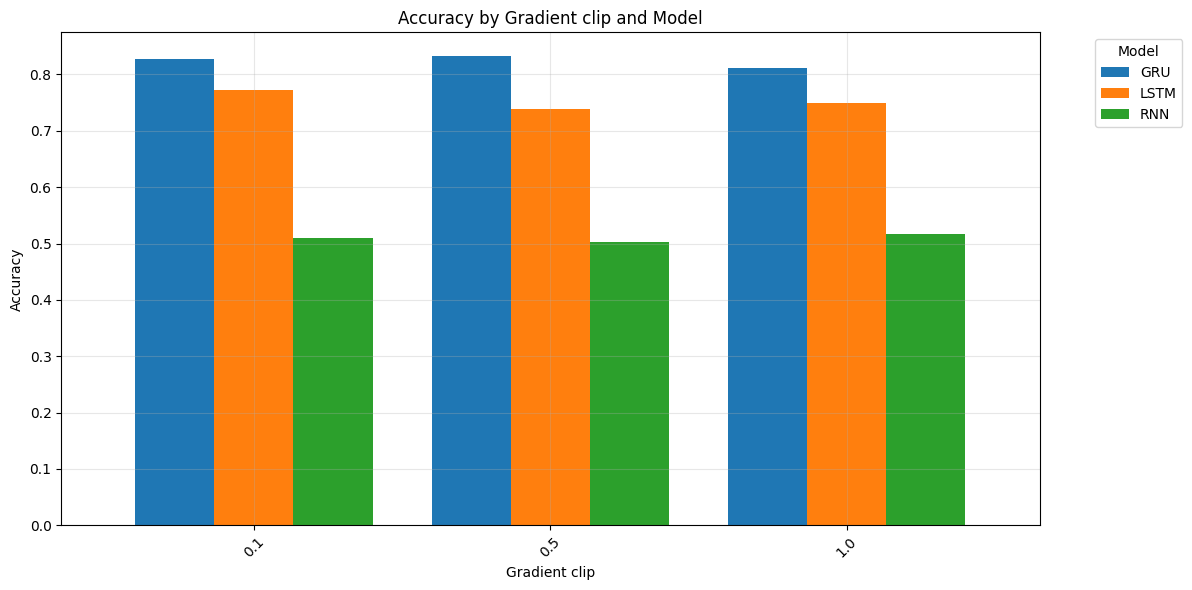


Detailed Accuracy Comparison by Gradient clip:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.1             0.8282  0.7726  0.5094
0.5             0.8331  0.7391  0.5019
1.0             0.8119  0.7486  0.5173


<Figure size 1200x600 with 0 Axes>

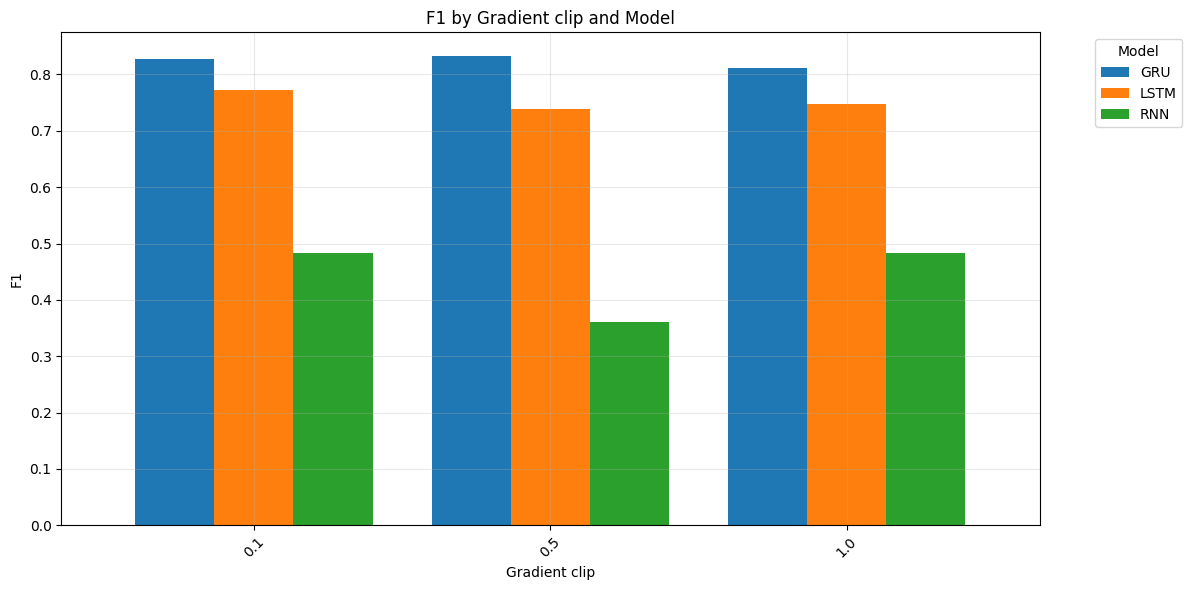


Detailed F1 Comparison by Gradient clip:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.1             0.8282  0.7722  0.4824
0.5             0.8331  0.7384  0.3601
1.0             0.8119  0.7477  0.4827


,Hyperparameter,Model,Metric
0,0.1,GRU,0.828194
1,0.1,LSTM,0.772187
2,0.1,RNN,0.482399
3,0.5,GRU,0.833087
4,0.5,LSTM,0.738390
5,0.5,RNN,0.360132
6,1.0,GRU,0.811890
7,1.0,LSTM,0.747698
8,1.0,RNN,0.482735


In [49]:
plot_model_comparison_by_hp(gradient_clipping_norm_test, 'gradient_clip', metric='Accuracy')
plot_model_comparison_by_hp(gradient_clipping_norm_test, 'gradient_clip', metric='F1')


RUNNING EXPERIMENT: LEARNING RATE 0.0001

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.7003, Train Acc: 49.96%
  Val Loss: 0.6950, Val Acc: 50.87%
Epoch 2/3:
  Train Loss: 0.6937, Train Acc: 51.12%
  Val Loss: 0.6936, Val Acc: 51.27%
Epoch 3/3:
  Train Loss: 0.6910, Train Acc: 51.86%
  Val Loss: 0.6934, Val Acc: 50.70%

RNN Evaluation Results:
Accuracy: 0.5070
Precision: 0.5097
Recall: 0.5070
F1-Score: 0.4705

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6938, Train Acc: 50.69%
  Val Loss: 0.6924, Val Acc: 51.62%
Epoch 2/3:
  Train Loss: 0.6917, Train Acc: 52.20%
  Val Loss: 0.6916, Val Acc: 52.01%
Epoch 3/3:
  Train Loss: 0.6898, Train Acc: 52.86%
  Val Loss: 0.6910, Val Acc: 51.20%

LSTM Evaluation Results:
Accuracy: 0.5120
Precision: 0.5171
Recall: 0.5120
F1-Score: 0.4726

Training GRU...

Training GRU...
---------------------------------------------

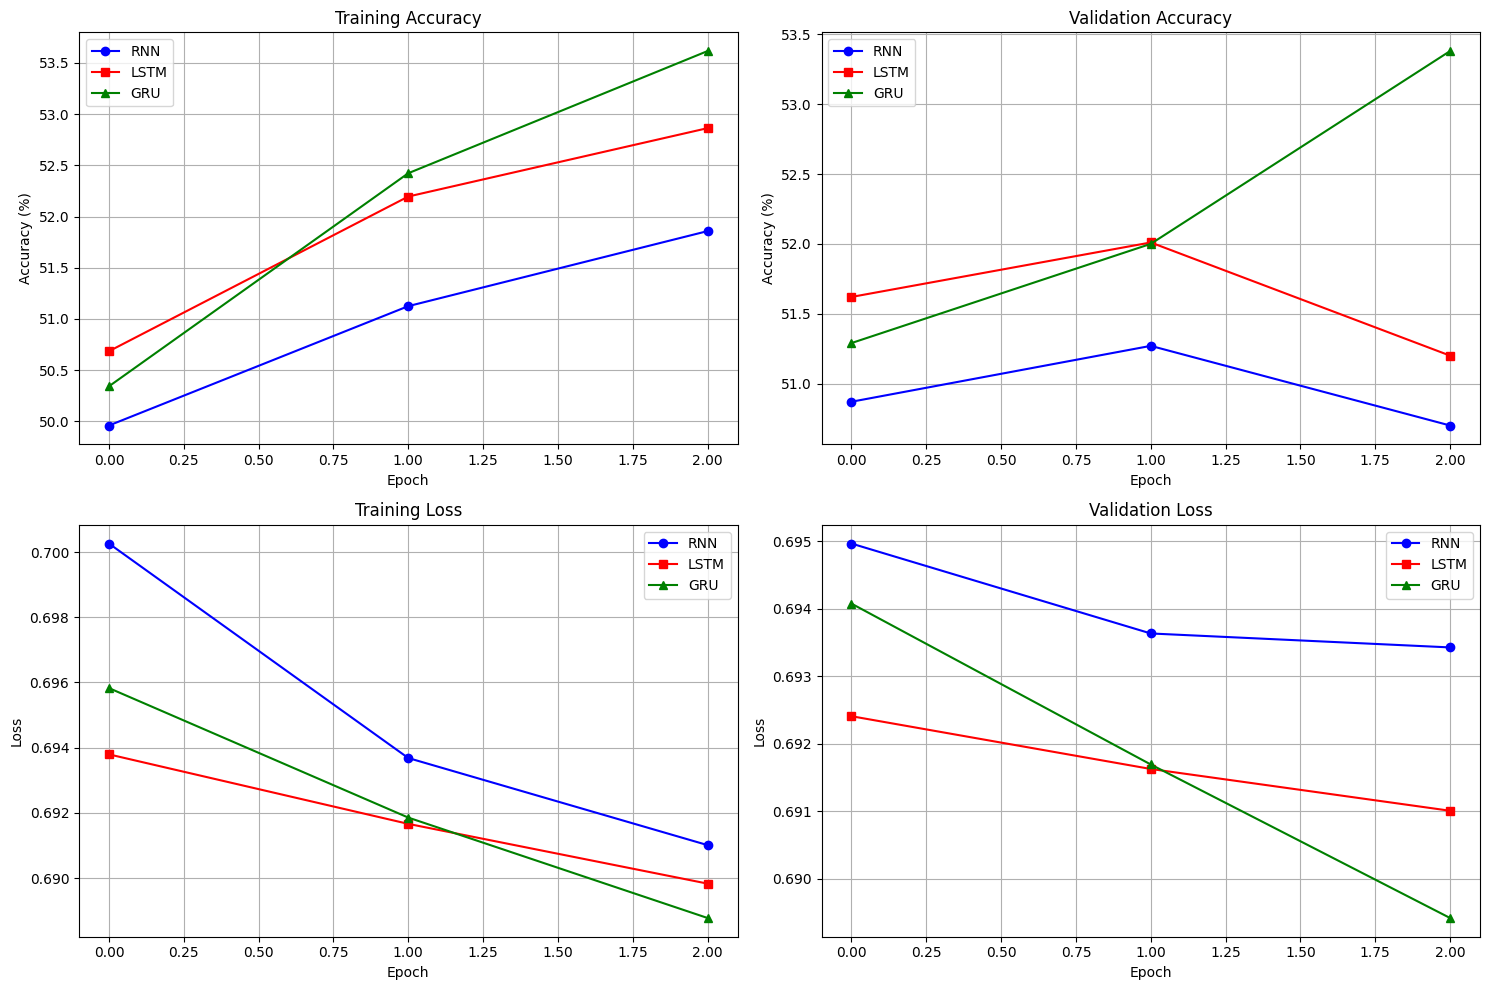

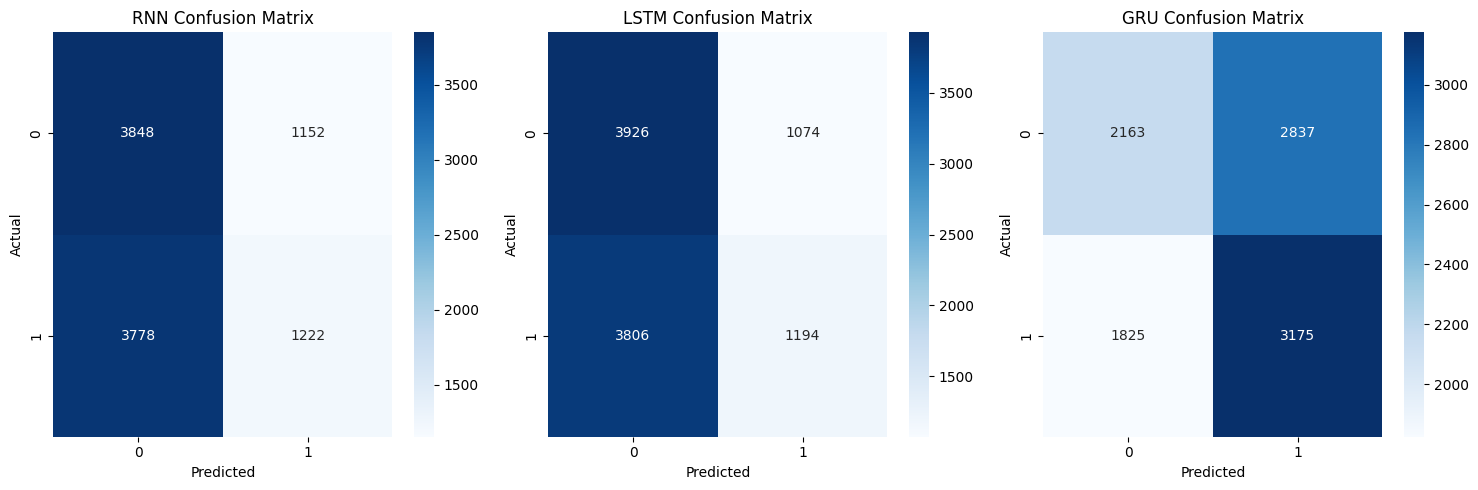


HYPERPARAMETERS USED
  - Embedding dimension: 128
  - Hidden size: 64
  - Dropout: 0.0
  - Learning rate: 0.0001
  - Epochs: 3
  - Batch size: 64

SUMMARY
Best performing model: GRU
Highest accuracy: 0.5338

RUNNING EXPERIMENT: LEARNING RATE 0.001

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6968, Train Acc: 50.65%
  Val Loss: 0.6950, Val Acc: 51.52%
Epoch 2/3:
  Train Loss: 0.6879, Train Acc: 53.44%
  Val Loss: 0.6899, Val Acc: 51.84%
Epoch 3/3:
  Train Loss: 0.6804, Train Acc: 54.58%
  Val Loss: 0.6930, Val Acc: 50.97%

RNN Evaluation Results:
Accuracy: 0.5097
Precision: 0.5136
Recall: 0.5097
F1-Score: 0.4720

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6905, Train Acc: 51.91%
  Val Loss: 0.6574, Val Acc: 64.16%
Epoch 2/3:
  Train Loss: 0.6234, Train Acc: 66.69%
  Val Loss: 0.5787, Val Acc: 71.36%
Epoch 3/3:
  Train Loss: 0.5287, Train Acc: 75.73%
 

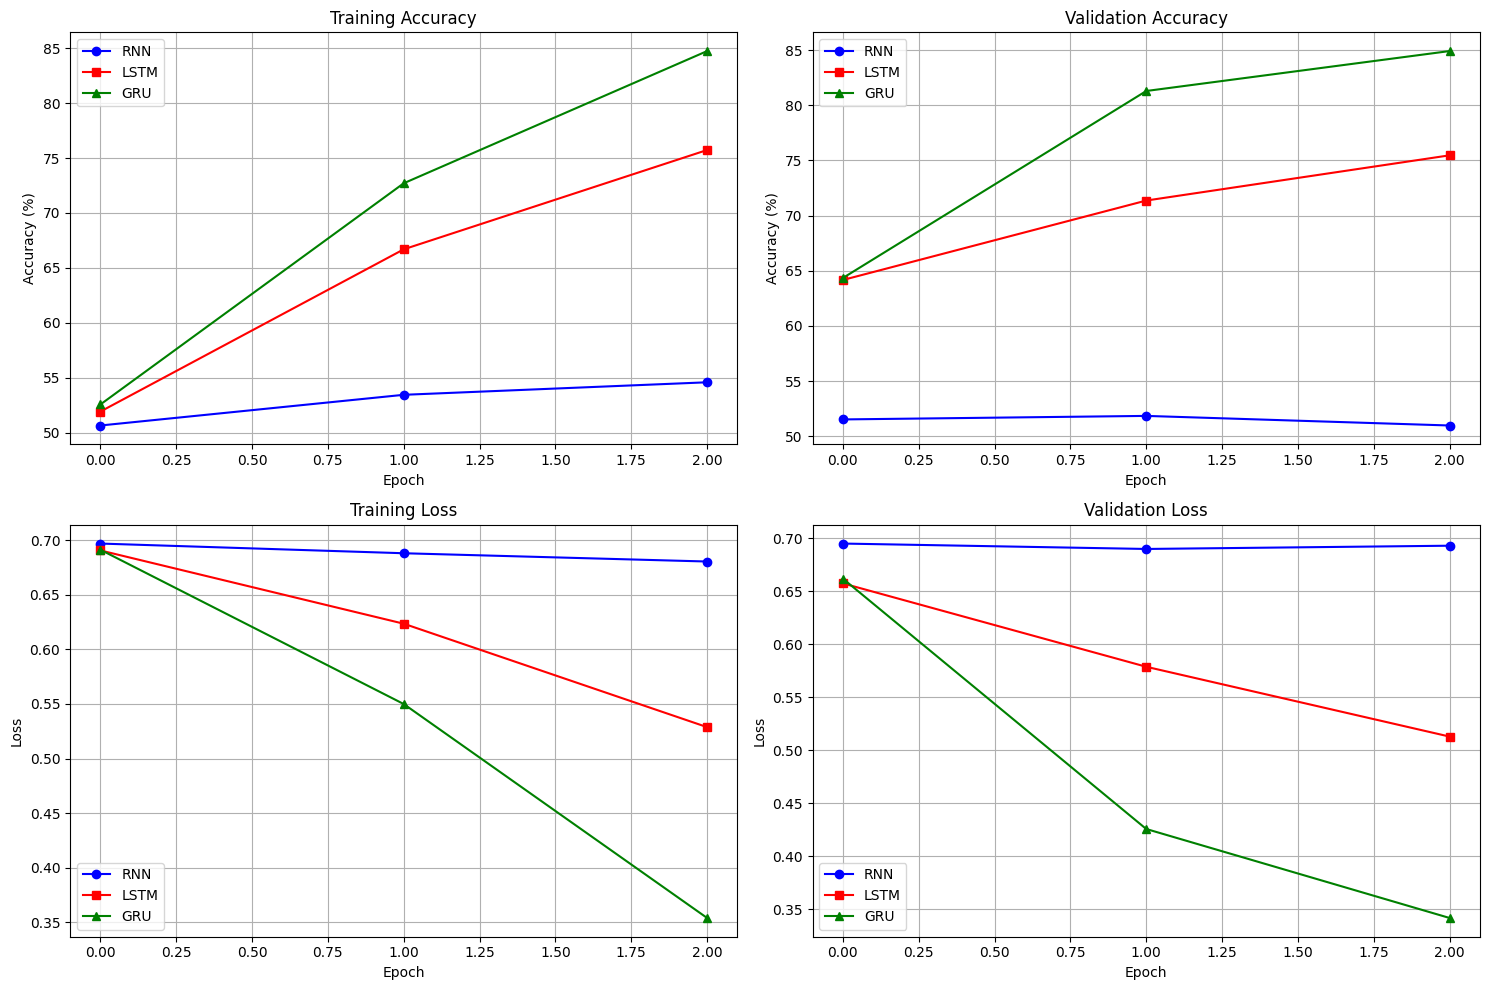

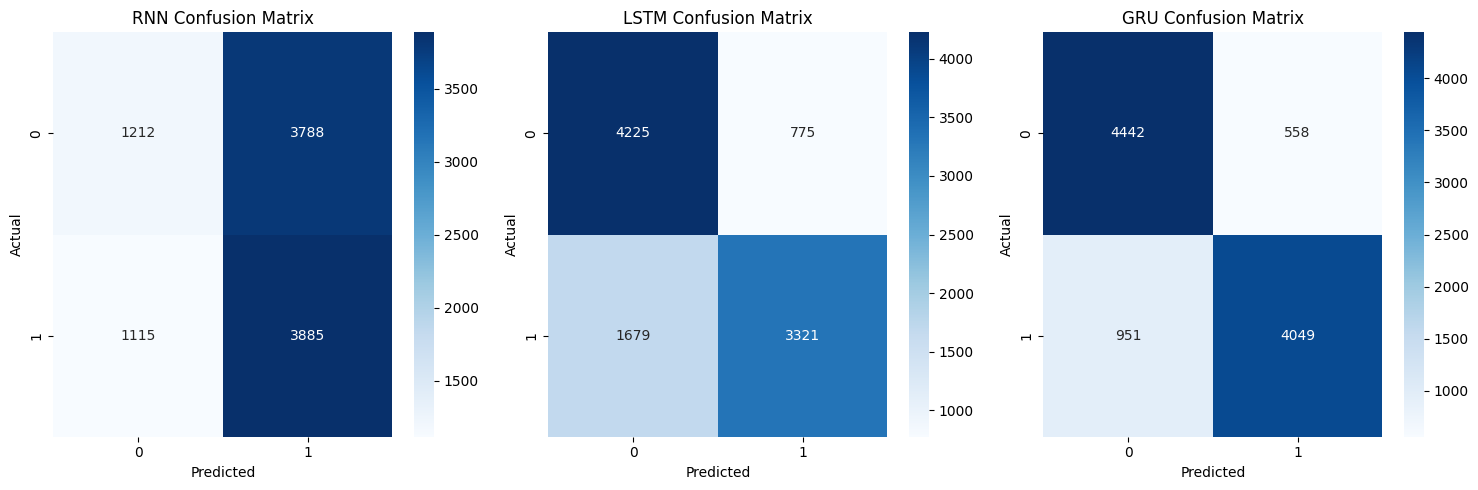


HYPERPARAMETERS USED
  - Embedding dimension: 128
  - Hidden size: 64
  - Dropout: 0.0
  - Learning rate: 0.001
  - Epochs: 3
  - Batch size: 64

SUMMARY
Best performing model: GRU
Highest accuracy: 0.8491

RUNNING EXPERIMENT: LEARNING RATE 0.01

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.7091, Train Acc: 50.40%
  Val Loss: 0.6965, Val Acc: 50.69%
Epoch 2/3:
  Train Loss: 0.7004, Train Acc: 52.62%
  Val Loss: 0.6973, Val Acc: 52.82%
Epoch 3/3:
  Train Loss: 0.6895, Train Acc: 54.58%
  Val Loss: 0.6960, Val Acc: 51.86%

RNN Evaluation Results:
Accuracy: 0.5186
Precision: 0.5286
Recall: 0.5186
F1-Score: 0.4726

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6696, Train Acc: 57.31%
  Val Loss: 0.6456, Val Acc: 62.06%
Epoch 2/3:
  Train Loss: 0.5223, Train Acc: 74.89%
  Val Loss: 0.4868, Val Acc: 77.65%
Epoch 3/3:
  Train Loss: 0.4429, Train Acc: 80.41%
  V

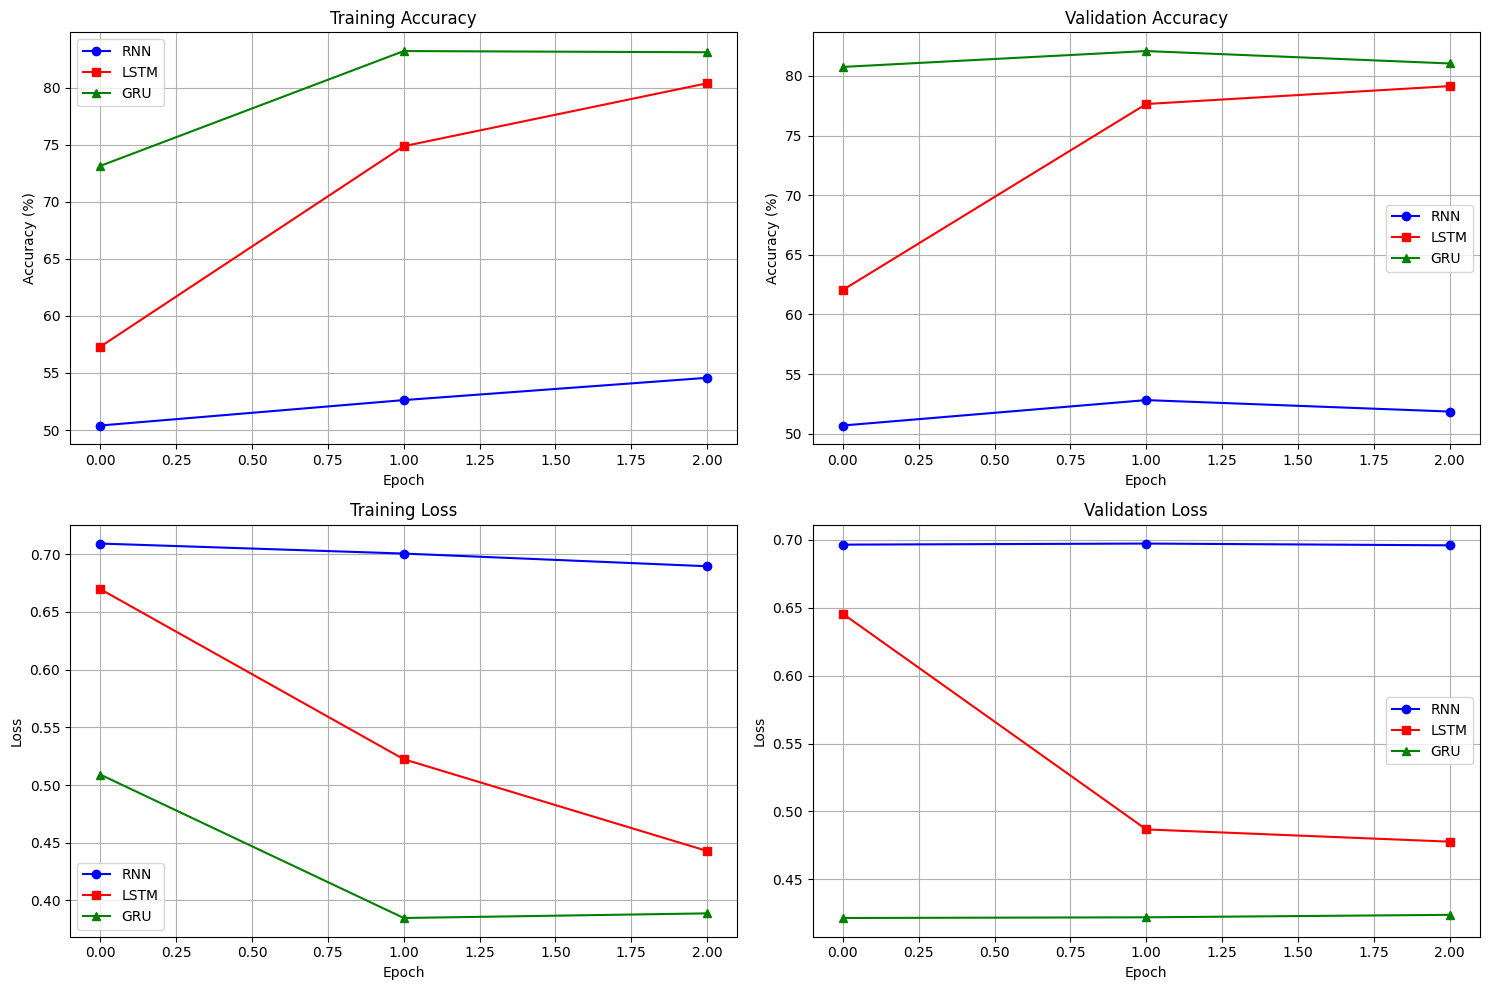

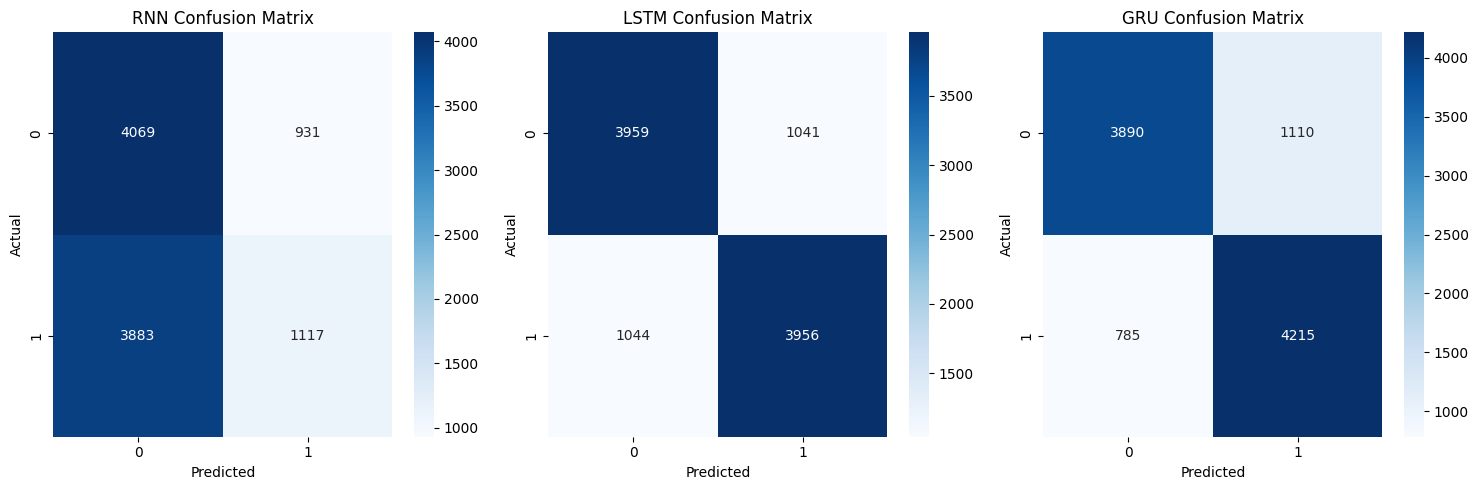


HYPERPARAMETERS USED
  - Embedding dimension: 128
  - Hidden size: 64
  - Dropout: 0.0
  - Learning rate: 0.01
  - Epochs: 3
  - Batch size: 64

SUMMARY
Best performing model: GRU
Highest accuracy: 0.8105

RUNNING EXPERIMENT: LEARNING RATE 0.1

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.8292, Train Acc: 50.25%
  Val Loss: 0.8024, Val Acc: 50.59%
Epoch 2/3:
  Train Loss: 0.8387, Train Acc: 50.06%
  Val Loss: 0.8555, Val Acc: 50.94%
Epoch 3/3:
  Train Loss: 0.8264, Train Acc: 50.39%
  Val Loss: 0.8950, Val Acc: 50.02%

RNN Evaluation Results:
Accuracy: 0.5002
Precision: 0.5003
Recall: 0.5002
F1-Score: 0.4644

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.7640, Train Acc: 50.43%
  Val Loss: 0.7385, Val Acc: 49.85%
Epoch 2/3:
  Train Loss: 0.7623, Train Acc: 50.23%
  Val Loss: 0.7405, Val Acc: 50.29%
Epoch 3/3:
  Train Loss: 0.7705, Train Acc: 50.31%
  Val

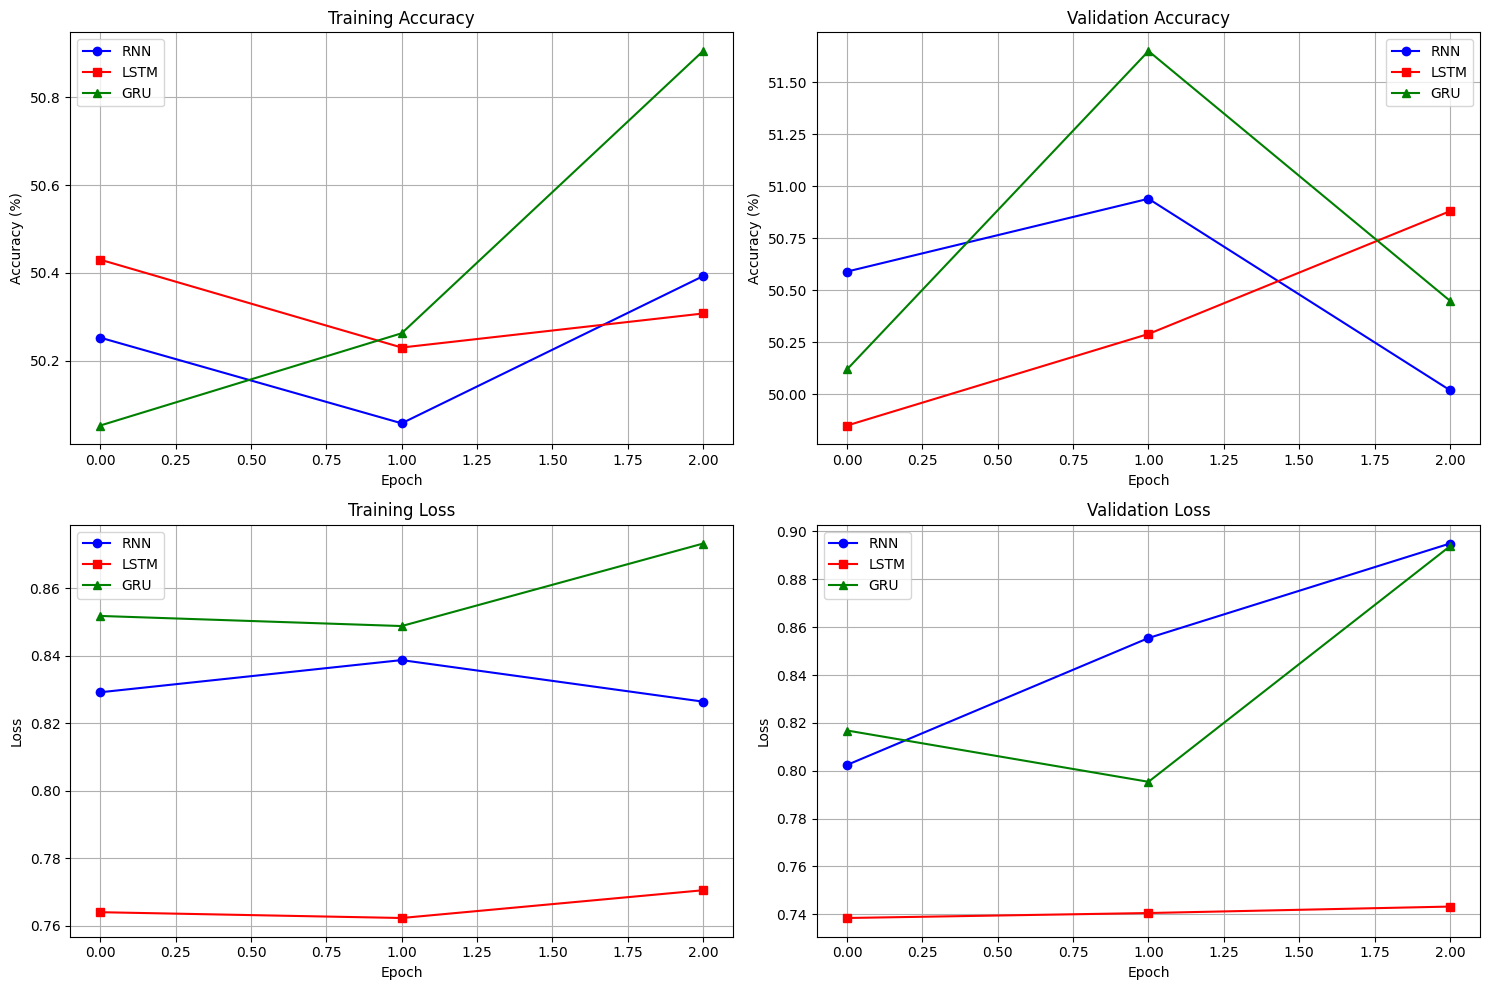

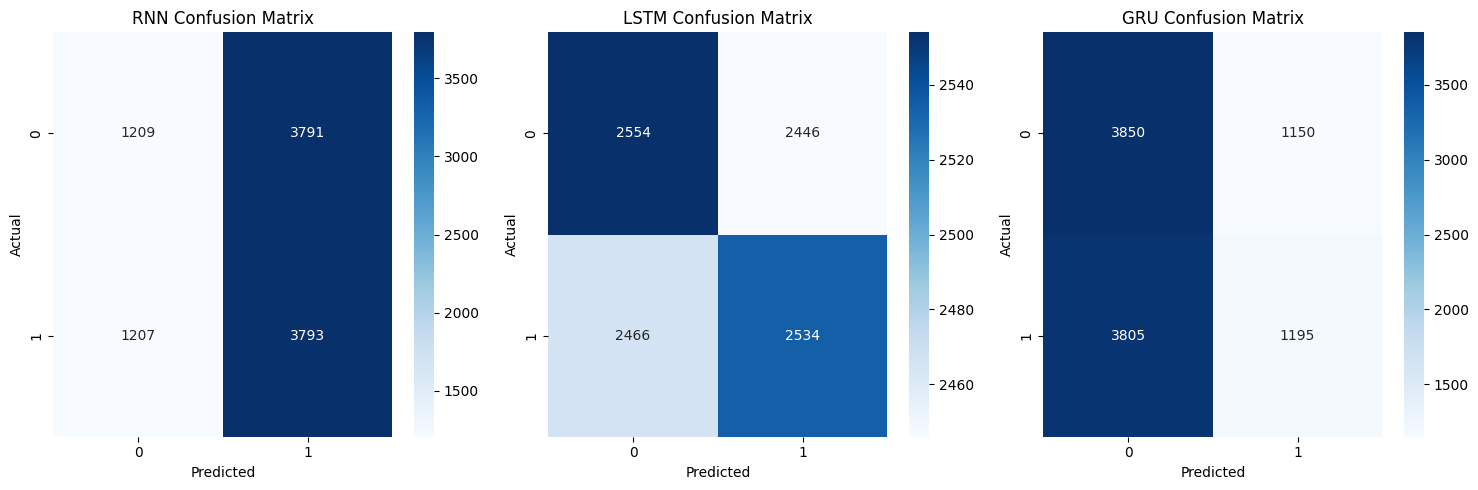


HYPERPARAMETERS USED
  - Embedding dimension: 128
  - Hidden size: 64
  - Dropout: 0.0
  - Learning rate: 0.1
  - Epochs: 3
  - Batch size: 64

SUMMARY
Best performing model: LSTM
Highest accuracy: 0.5088


In [ ]:
# DEPRE

# # Test learning rates
# lr_experiments = {}
# for lr in [0.0001, 0.001, 0.01, 0.1]:
#     exp_name = f"Learning Rate {lr}"
#     lr_experiments[exp_name] = run_hyperparameter_experiment(
#         embedding_dim=128,
#         hidden_size=64,
#         dropout=0.0,
#         learning_rate=lr,
#         epochs=3,
#         batch_size=64,
#         experiment_name=exp_name
#     )

In [ ]:
# Example: Hyperparameter Tuning Experiments
# Uncomment and run these to test different hyperparameter configurations

# Example 1: Test different hidden sizes
# hidden_size_experiments = {}
# for hidden_size in [32, 64, 128, 256]:
#     exp_name = f"Hidden Size {hidden_size}"
#     hidden_size_experiments[exp_name] = run_hyperparameter_experiment(
#         embedding_dim=128,
#         hidden_size=hidden_size,
#         dropout=0.0,
#         learning_rate=0.001,
#         epochs=3,
#         batch_size=64,
#         experiment_name=exp_name
#     )

# Example 2: Test different dropout rates
# dropout_experiments = {}
# for dropout in [0.0, 0.2, 0.4, 0.6]:
#     exp_name = f"Dropout {dropout}"
#     dropout_experiments[exp_name] = run_hyperparameter_experiment(
#         embedding_dim=128,
#         hidden_size=64,
#         dropout=dropout,
#         learning_rate=0.001,
#         epochs=3,
#         batch_size=64,
#         experiment_name=exp_name
#     )

# Example 3: Test different learning rates
# lr_experiments = {}
# for lr in [0.0001, 0.001, 0.01, 0.1]:
#     exp_name = f"Learning Rate {lr}"
#     lr_experiments[exp_name] = run_hyperparameter_experiment(
#         embedding_dim=128,
#         hidden_size=64,
#         dropout=0.0,
#         learning_rate=lr,
#         epochs=3,
#         batch_size=64,
#         experiment_name=exp_name
#     )

# Example 4: Test different embedding dimensions
# embedding_experiments = {}
# for emb_dim in [64, 128, 256, 512]:
#     exp_name = f"Embedding Dim {emb_dim}"
#     embedding_experiments[exp_name] = run_hyperparameter_experiment(
#         embedding_dim=emb_dim,
#         hidden_size=64,
#         dropout=0.0,
#         learning_rate=0.001,
#         epochs=3,
#         batch_size=64,
#         experiment_name=exp_name
#     )

# Example 5: Compare experiments across different hyperparameters
# all_experiments = {
#     **hidden_size_experiments,
#     **dropout_experiments,
#     **lr_experiments,
#     **embedding_experiments
# }

# # Create comparison across all experiments
# experiment_comparison_dfs = {name: exp['comparison_df'] for name, exp in all_experiments.items()}
# plot_hyperparameter_comparison(experiment_comparison_dfs, metric='Accuracy')

print("Hyperparameter tuning examples ready!")
print("Uncomment the sections above to run different experiments.")
print("\nUsage examples:")
print("1. Test different hidden sizes: hidden_size_experiments")
print("2. Test different dropout rates: dropout_experiments") 
print("3. Test different learning rates: lr_experiments")
print("4. Test different embedding dimensions: embedding_experiments")
print("5. Compare all experiments: plot_hyperparameter_comparison()")
